<a href="https://colab.research.google.com/github/KarelZe/thesis/blob/feature-engineering/notebooks/3.0a-mb-explanatory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gcsfs==2022.10.0
!pip install scikit-learn==1.1.3
!pip install pandas-datareader==0.10.0
!pip install seaborn==0.12.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement scikit-learn==1.1.3 (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0b1, 0.15.0b2, 0.15.0, 0.15.1, 0.15.2, 0.16b1, 0.16.0, 0.16.1, 0.17b1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19b2, 0.19.0, 0.19.1, 0.19.2, 0.20rc1, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21rc2, 0.21.0, 0.21.1, 0.21.2, 0.21.3, 0.22rc2.post1, 0.22rc3, 0.22, 0.22.1, 0.22.2, 0.22.2.post1, 0.23.0rc1, 0.23.0, 0.23.1, 0.23.2, 0.24.dev0, 0.24.0rc1, 0.24.0, 0.24.1, 0.24.2, 1.0rc1, 1.0rc2, 1.0, 1.0.1, 1.0.2)
ERROR: No matching distribution found for scikit-learn==1.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/co

In [3]:
import os
import random

import dateutil.relativedelta as relativedelta

import gcsfs
import google.auth
from google.colab import auth

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web

from scipy import stats

import seaborn as sns
from typing import Any, List, Optional, Union


In [4]:
# set N used in n-largest or smallest
N = 10


In [5]:
# set style
plt.style.use("seaborn-notebook")

# set ratio of figure
ratio = (16, 9)


In [6]:
# connect to google cloud storage
auth.authenticate_user()
credentials, _ = google.auth.default()
fs = gcsfs.GCSFileSystem(project="thesis", token=credentials)
fs_prefix = "gs://"


In [7]:
# set fixed seed
def seed_everything(seed) -> None:
    """
    Seeds basic parameters for reproducibility of results.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    # pandas and numpy as discussed here: https://stackoverflow.com/a/52375474/5755604
    np.random.seed(seed)


seed = 42
seed_everything(seed)


In [8]:
# replace with sampled data set later
files = fs.glob(
    "thesis-bucket-option-trade-classification/data/preprocessed/matched_ise_quotes_min_mem_usage_part_*.parquet",
    recursive=True,
)
files = [fs_prefix + sub for sub in files]

columns = [
    "UNDERLYING_SYMBOL",
    "QUOTE_DATETIME",
    "SEQUENCE_NUMBER",
    "ROOT",
    "EXPIRATION",
    "STRK_PRC",
    "OPTION_TYPE",
    "TRADE_SIZE",
    "TRADE_PRICE",
    "BEST_BID",
    "BEST_ASK",
    "order_id",
    "ask_ex",
    "bid_ex",
    "bid_size_ex",
    "ask_size_ex",
    "price_all_lead",
    "price_all_lag",
    "optionid",
    "day_vol",
    "price_ex_lead",
    "price_ex_lag",
    "buy_sell",
]

# concat data frame in a row-wise manner
dfs = []
for gc_file in files:
    df = pd.read_parquet(gc_file, columns=columns)
    dfs.append(df)
data = pd.concat(dfs)


In [9]:
data = data.sample(frac=0.1, axis=0, random_state=seed)


## Notes on data set 🗃️

**Overview on ticker symbols:**
- `others` identified by issue type.
- 5th letter has a special meaning as found in [this table](https://en.wikipedia.org/wiki/Ticker_symbol):

| Letter                  | Letter contd.              | Letter contd.                                    |
|--------------------------------|-------------------------------------|------------------------------------------------|
| A – Class "A"                  | K – Nonvoting (common)              | U – Units                                      |
| B – Class "B"                  | L – Miscellaneous                   | V – Pending issue and distribution             |
| C – NextShares                 | M – fourth class – preferred shares | W – Warrants                                   |
| D – New issue or reverse split | N – third class – preferred shares  | X – Mutual fund                                |
| E – Delinquent SEC filings     | O – second class – preferred shares | Y – American depositary receipt (ADR)          |
| F – Foreign                    | P – first class preferred shares    | Z – Miscellaneous situations                   |
| G – first convertible bond     | Q – In bankruptcy                   | Special codes                                  |
| H – second convertible bond    | R – Rights                          | PK – A Pink Sheet, indicating over-the-counter |
| I – third convertible bond     | S – Shares of beneficial interest   | SC – Nasdaq Small Cap                          |
| J – Voting share – special     | T – With warrants or rights         | NM – Nasdaq National Market                    |


**Coverage:**

*	Options on U.S. listed Stock, ETFs, and Indices disseminated over the Options Price Reporting Authority (OPRA) market data feed 
*	Global Trading Hours (GTH) trades are included if between 03:00am-09:15am U.S. Eastern, and for the 16:15pm 17:00pm Curb session.  GTH trades outside of these time ranges will *not* be included. 

Found [here.](https://datashop.cboe.com/documents/Option_Trades_Layout.pdf)

**Exchange Identifier:**

- 5 = Chicago Board Options Exchange (CBOE)
- 6 = International Securities Exchange (ISE)

Found [here.](https://datashop.cboe.com/documents/livevol_exchange_ids.csv)


**Issue Types:**

Issue Type = the type of security: 
- 0 = Common Stock 
- A = Market index 
- 7 = Mutual or investment trust fund 
- F = ADR/ADS 
- % = Exchange-traded fund 
- (blank) = Unspecified

Received from supervisor.

Adapted from the cboe data shop found at [option trades](https://datashop.cboe.com/documents/Option_Trades_Layout.pdf) and [option quotes](https://datashop.cboe.com/documents/Option_Quotes_Layout.pdf).

|     Column Label                                                          |     Data   Type     |     Description                                                                                                                                                                                                         |
|---------------------------------------------------------------------------|---------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|     underlying_symbol                                                     |     string          |     The underlying stock or index.  An index will utilize a caret (^) prefix,   i.e. ^NDX,^SPX,^VIX…etc.  Underlyings   with classes may utilize a dot (.) instead of a slash or space, i.e. BRK.B,   RDS.A, RDS.B.     |
|     quote_datetime                                                        |     datetime        |     The trading date and timestamp of the trade in   U.S. Eastern time. Ex:  yyyymm-dd   hh:mm:ss.000                                                                                                                   |
|     sequence_number                                                       |     integer         |     Trade Sequence Number for the execution reported   by OPRA                                                                                                                                                          |
|     root                                                                  |     string          |     The option trading class symbol.  Non-standard roots may end with a digit                                                                                                                                           |
|     expiration                                                            |     date            |     The explicit expiration date of the option:   yyyy-mm-dd                                                                                                                                                            |
|     strike                                                                |     numeric         |     The exercise/strike price of the option                                                                                                                                                                             |
|     option_type                                                           |     string          |     C for Call options, P for Put options                                                                                                                                                                               |
|     exchange_id                                                           |     integer         |     An identifier for the options exchange the trade   was executed on.  For a mapping, please   see Exchange ID   Mappings                                                                                             |
|     trade_size                                                            |     integer         |     The trade quantity                                                                                                                                                                                                  |
|     trade_price                                                           |     numeric         |     The trade price                                                                                                                                                                                                     |
|     trade_condition_id                                                    |     integer         |     The trade or sale condition of the execution.  For a mapping, please see Trade   Condition ID Mapping                                                                                                               |
|     canceled_trade_condition_id                                           |     integer         |     This field is no longer supported and will default   to 0 (zero).  See IDs 40-43 in the   Trade Condition ID Mapping file above                                                                                     |
|     best_bid                                                              |     numeric         |     The best bid price (NBB) at the time of the trade                                                                                                                                                                   |
|     best_ask                                                              |     numeric         |     The best ask/offer price (NBO) at the time of the   trade                                                                                                                                                           |
|     bid_size              |     integer         |     The largest size from an options exchange   participant on the best bid price (NBB)                                                                                                                                   |
|     bid                   |     numeric         |     The best bid price (NBB) at the interval time   stamp                                                                                                                                                                 |
|     ask_size              |     integer         |     The largest size from an options exchange   participant on the best offer price (NBO)                                                                                                                                 |
|     ask                   |     numeric         |     The best offer price (NBO) at the interval time   stamp                                                                                                                                                               |

## Dtypes, distributions, and memory consumption 🔭

In [10]:
data.head()


,UNDERLYING_SYMBOL,QUOTE_DATETIME,SEQUENCE_NUMBER,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,...,bid_ex,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,buy_sell
26219414,NVDA,2013-01-22 13:03:56,21376317,NVDA,2013-02-16,13.000000,P,11,1.04,1.02,...,1.02,51.0,281.0,1.03,1.05,100237952.0,122.0,1.03,1.05,1
35222168,BABA,2015-02-26 14:09:31,140918805,BABA,2015-09-18,70.000000,P,1,1.77,1.77,...,1.77,208.0,71.0,1.80,2.19,106745328.0,1.0,1.83,2.12,-1
46995646,ENDP,2017-01-30 11:18:25,22918467,ENDP,2017-07-21,15.000000,C,20,1.08,0.95,...,0.95,53.0,37.0,1.10,1.10,113865992.0,166.0,1.07,1.15,1
289738,BBBY,2005-06-20 13:41:23,31667806,BHQ,2005-07-16,47.500000,P,1,3.90,3.80,...,3.80,1001.0,608.0,4.00,3.60,25991408.0,1.0,4.00,3.60,1
33645515,AAPL,2014-09-17 13:24:38,1624573500,AAPL,2015-01-17,128.570007,C,5,0.36,0.34,...,0.33,44.0,5.0,0.38,0.35,83244120.0,43.0,0.37,0.35,1


In [11]:
data.describe()


,SEQUENCE_NUMBER,STRK_PRC,TRADE_SIZE,TRADE_PRICE,BEST_BID,BEST_ASK,order_id,ask_ex,bid_ex,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,buy_sell
count,4.920375e+06,4.920375e+06,4.920375e+06,4.920375e+06,4.920375e+06,4.920375e+06,4.920375e+06,4.883226e+06,4.883226e+06,4.883226e+06,4.883226e+06,4.757705e+06,4.814839e+06,4917021.0,4.920375e+06,4.445261e+06,4.505693e+06,4.920375e+06
mean,3.245129e+08,1.109298e+02,1.360620e+01,4.975645e+00,4.849421e+00,5.181332e+00,6.489977e+08,5.144516e+00,4.831182e+00,2.671749e+02,2.803008e+02,5.005047e+00,4.960274e+00,73407760.0,7.469988e+01,5.031496e+00,5.010355e+00,-5.138043e-02
std,7.336937e+08,3.514656e+02,7.674520e+01,1.571387e+01,1.555641e+01,1.286473e+02,5.092863e+08,1.593417e+01,1.555197e+01,1.117508e+03,1.193500e+03,1.640996e+01,1.542698e+01,33231944.0,4.013414e+02,1.558659e+01,1.529230e+01,9.986793e-01
min,1.690000e+02,5.000000e-01,1.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,6.580000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-02,1.000000e-02,21058526.0,1.000000e+00,1.000000e-02,1.000000e-02,-1.000000e+00
25%,2.576965e+07,2.500000e+01,1.000000e+00,4.600000e-01,4.000000e-01,5.000000e-01,2.237885e+08,5.200000e-01,4.000000e-01,2.000000e+01,2.100000e+01,5.000000e-01,5.000000e-01,42726336.0,3.000000e+00,5.000000e-01,5.500000e-01,-1.000000e+00
50%,5.766016e+07,4.500000e+01,4.000000e+00,1.550000e+00,1.460000e+00,1.600000e+00,4.601352e+08,1.650000e+00,1.450000e+00,5.700000e+01,6.300000e+01,1.580000e+00,1.560000e+00,81428168.0,1.000000e+01,1.600000e+00,1.630000e+00,-1.000000e+00
75%,1.171775e+08,8.500000e+01,1.000000e+01,4.300000e+00,4.200000e+00,4.500000e+00,1.067678e+09,4.500000e+00,4.150000e+00,1.980000e+02,2.140000e+02,4.350000e+00,4.300000e+00,106696136.0,3.500000e+01,4.400000e+00,4.400000e+00,1.000000e+00
max,4.294960e+09,7.000000e+03,4.833200e+04,2.281980e+03,2.278100e+03,2.000010e+05,1.737958e+09,2.283500e+03,2.278100e+03,9.999900e+04,9.999900e+04,9.999050e+03,2.281930e+03,128536568.0,5.530300e+04,2.281990e+03,2.281990e+03,1.000000e+00


In [12]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4920375 entries, 26219414 to 10636353
Data columns (total 23 columns):
 #   Column             Dtype         
---  ------             -----         
 0   UNDERLYING_SYMBOL  object        
 1   QUOTE_DATETIME     datetime64[ns]
 2   SEQUENCE_NUMBER    int64         
 3   ROOT               object        
 4   EXPIRATION         datetime64[ns]
 5   STRK_PRC           float32       
 6   OPTION_TYPE        category      
 7   TRADE_SIZE         int64         
 8   TRADE_PRICE        float32       
 9   BEST_BID           float32       
 10  BEST_ASK           float32       
 11  order_id           int64         
 12  ask_ex             float32       
 13  bid_ex             float32       
 14  bid_size_ex        float32       
 15  ask_size_ex        float32       
 16  price_all_lead     float32       
 17  price_all_lag      float32       
 18  optionid           float32       
 19  day_vol            float32       
 20  price_ex_lead   

In [13]:
print(data.shape)


(4920375, 23)


In [14]:
print(data.shape)
# drop identical rows, if present
data.drop_duplicates(inplace=True)
print(data.shape)


(4920375, 23)
(4920375, 23)


**Observation:**
- Shape matches the shape reported in table 1 (panel A) of Grauer et al. paper.
- No duplicates

In [15]:
data.nunique()


UNDERLYING_SYMBOL       5208
QUOTE_DATETIME       4477584
SEQUENCE_NUMBER      4832719
ROOT                   10225
EXPIRATION               526
STRK_PRC                3085
OPTION_TYPE                2
TRADE_SIZE              1848
TRADE_PRICE            20637
BEST_BID               10037
BEST_ASK               10155
order_id             4917071
ask_ex                 10047
bid_ex                  9857
bid_size_ex            14833
ask_size_ex            15113
price_all_lead         19098
price_all_lag          19011
optionid             1245471
day_vol                 4532
price_ex_lead          19830
price_ex_lag           19682
buy_sell                   2
dtype: int64

In [16]:
data.head().T


,26219414,35222168,46995646,289738,33645515
UNDERLYING_SYMBOL,NVDA,BABA,ENDP,BBBY,AAPL
QUOTE_DATETIME,2013-01-22 13:03:56,2015-02-26 14:09:31,2017-01-30 11:18:25,2005-06-20 13:41:23,2014-09-17 13:24:38
SEQUENCE_NUMBER,21376317,140918805,22918467,31667806,1624573500
ROOT,NVDA,BABA,ENDP,BHQ,AAPL
EXPIRATION,2013-02-16 00:00:00,2015-09-18 00:00:00,2017-07-21 00:00:00,2005-07-16 00:00:00,2015-01-17 00:00:00
STRK_PRC,13.0,70.0,15.0,47.5,128.570007
OPTION_TYPE,P,P,C,P,C
TRADE_SIZE,11,1,20,1,5
TRADE_PRICE,1.04,1.77,1.08,3.9,0.36
BEST_BID,1.02,1.77,0.95,3.8,0.34


## Basic features🧸

Analysis of numerical features without any feature engineering.

### Correlations 🎲

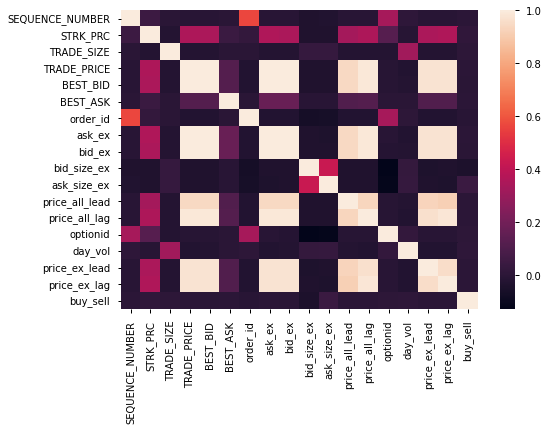

In [17]:
corr: pd.DataFrame = data.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)  # type: ignore


**Observation:**
* There are many highly correlated columns. The correlations are intuitive e. g., between `price_all_lead` and `price_ex_lead`.
* Few columns show a weak correlation with target (see also below).

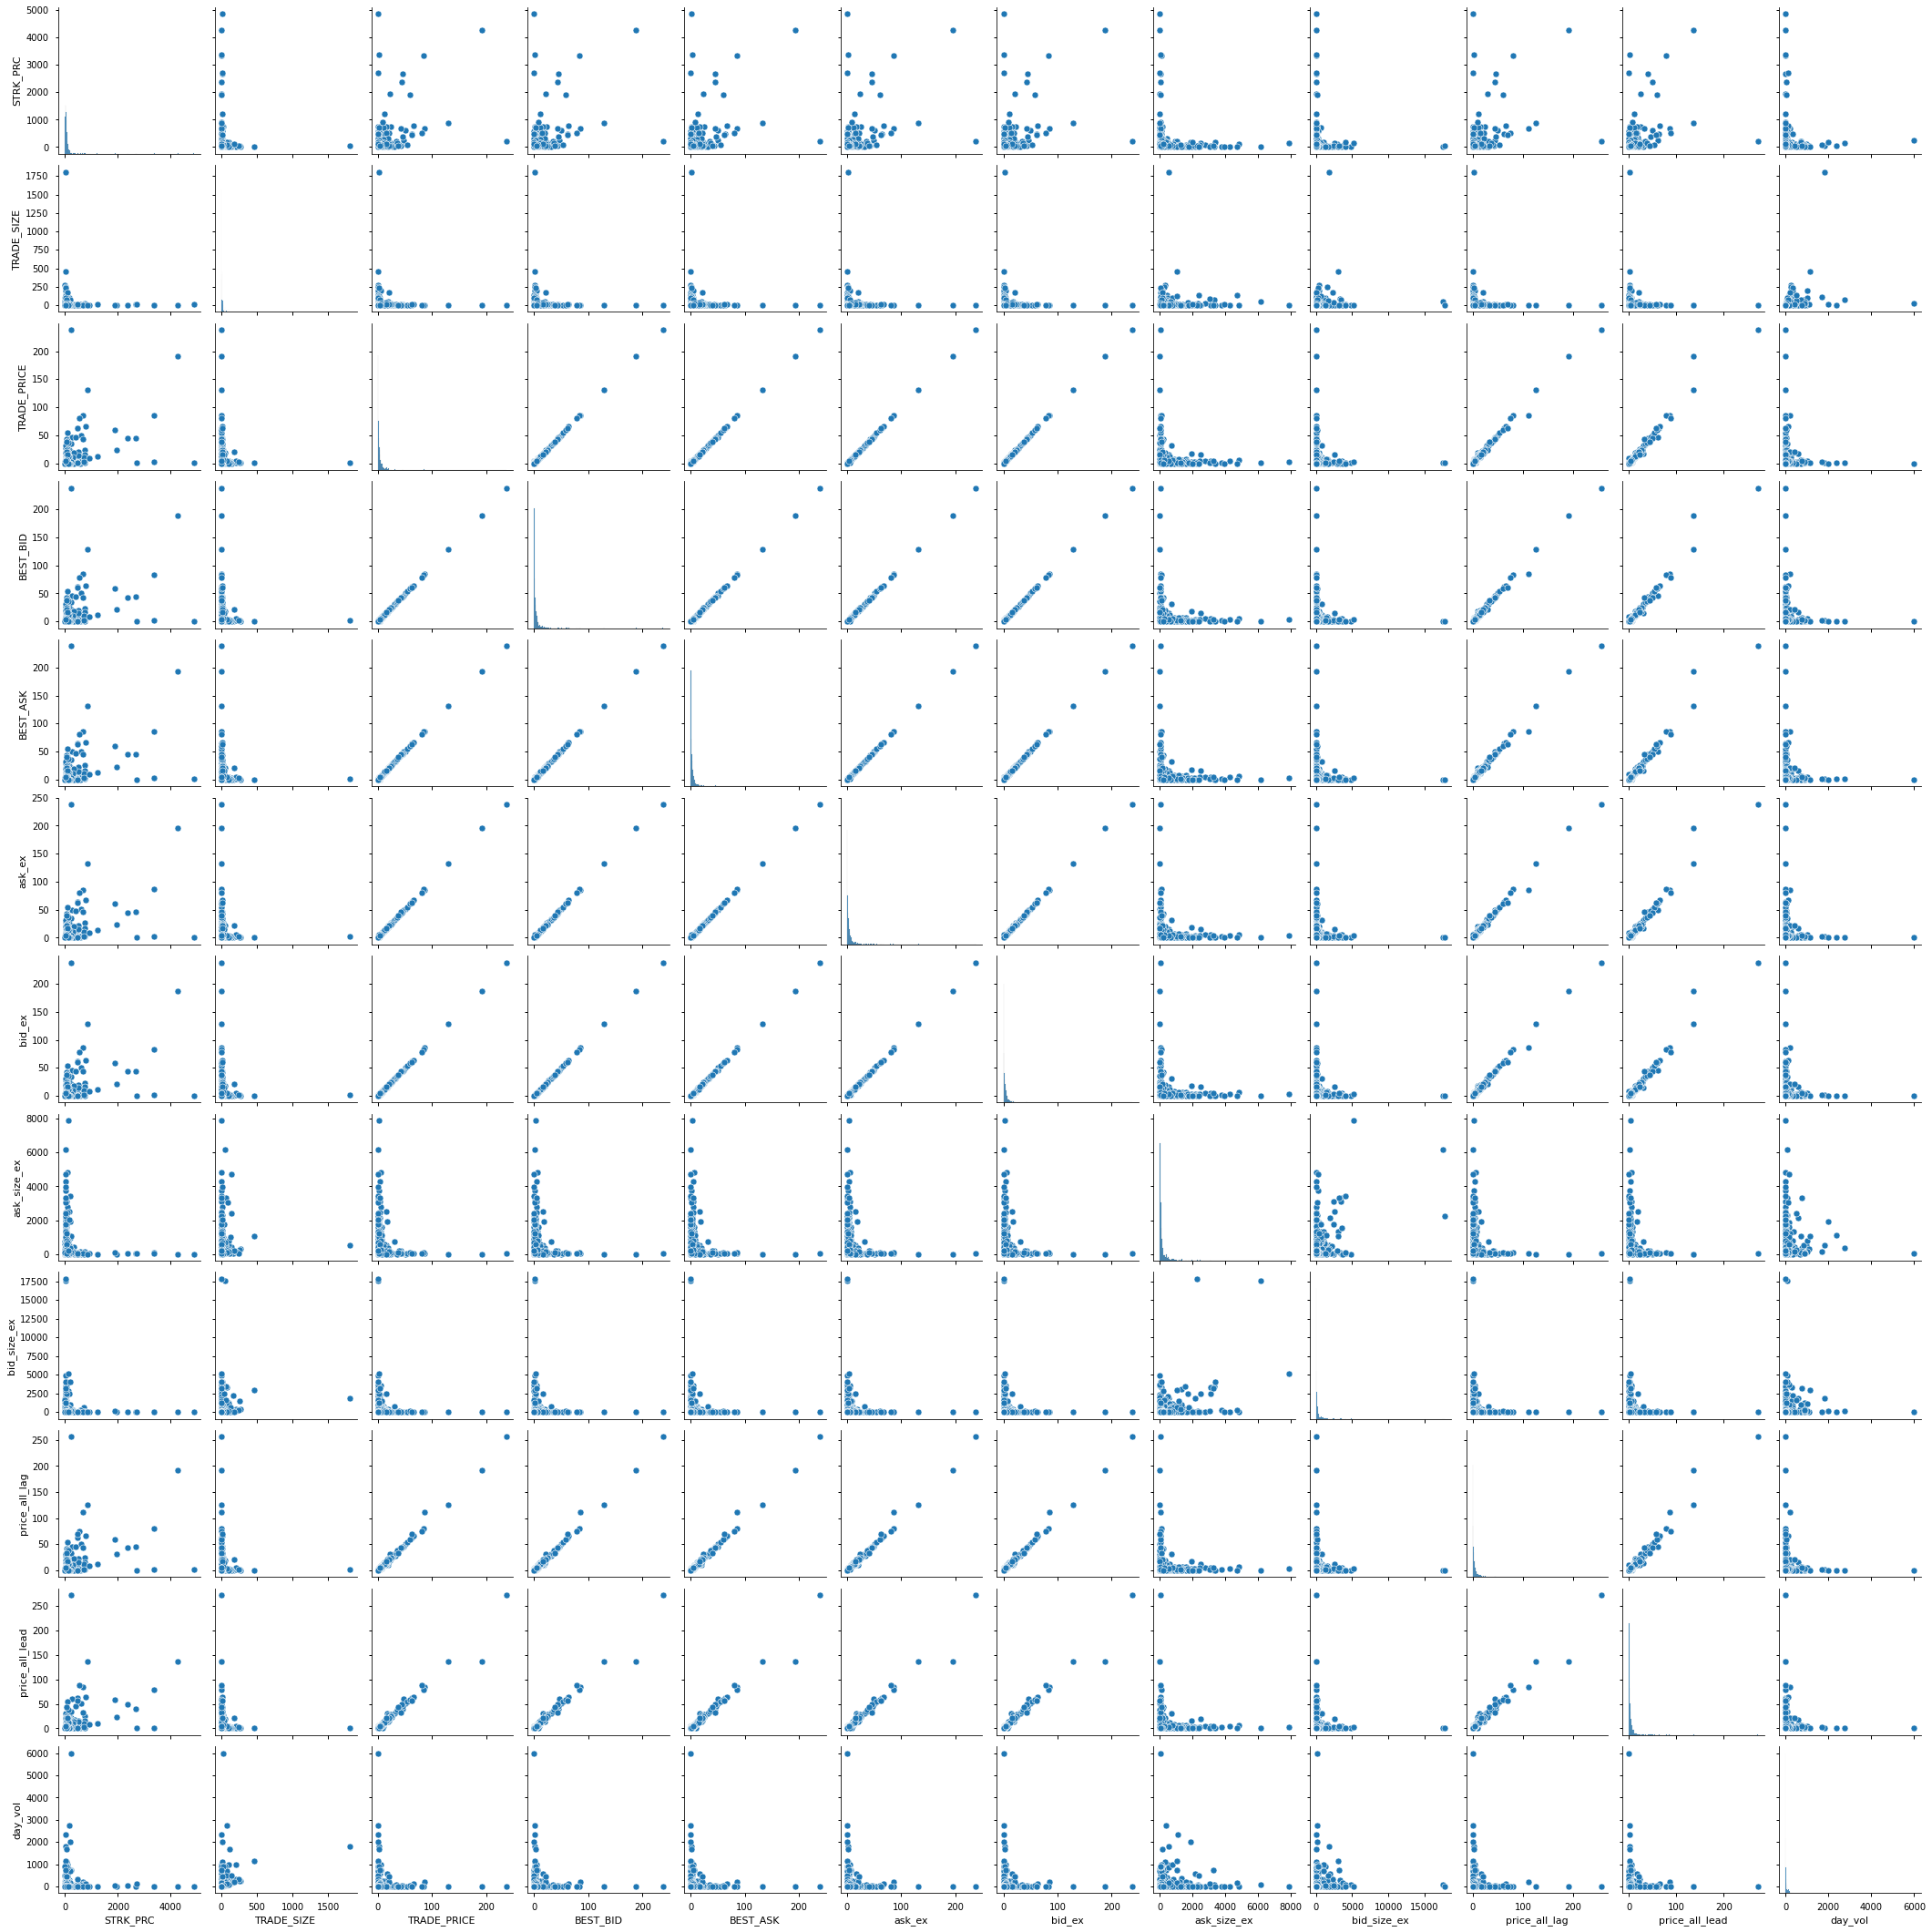

In [18]:
sample = data.sample(n=1000, random_state=seed)
sns.pairplot(
    sample,
    vars=[
        "STRK_PRC",
        "TRADE_SIZE",
        "TRADE_PRICE",
        "BEST_BID",
        "BEST_ASK",
        "ask_ex",
        "bid_ex",
        "ask_size_ex",
        "bid_size_ex",
        "price_all_lag",
        "price_all_lead",
        "day_vol",
    ],
)


### Correlation with target 🎲

In [19]:
sort_criteria = corr["buy_sell"].abs().sort_values(ascending=False)
corr_target = corr.sort_values("buy_sell", ascending=False)["buy_sell"]
corr_target.loc[sort_criteria.index].to_frame()


,buy_sell
buy_sell,1.000000
ask_size_ex,0.045592
bid_size_ex,-0.042428
STRK_PRC,0.013027
day_vol,0.010908
optionid,0.007770
TRADE_SIZE,0.007162
order_id,-0.005313
price_ex_lead,0.003365
price_all_lead,0.000767


**Observation:**
* Overall correlations are relatively low. Typical for financial data due to low signal-to-noise ratio.
* Size-related features like `ask_size_ex` or `bid_size_ex` have the highest correlation with the target. Thus, can be promising to be included in the model. Consider size features when constructing feature sets.
* Features like `optionid`, `order_id`, and `SEQUENCE_NUMBER` are also among the features with the highest correlations. Remove them, as the correlation is misleading.

In [20]:
# remove some columns, which will NOT be used in model
data.drop(columns=["optionid", "SEQUENCE_NUMBER", "order_id"], inplace=True)


In [21]:
# just keep ROOT
data.drop(columns="UNDERLYING_SYMBOL", inplace=True)


### Collinearity of features 🎲

In [22]:
# adapted from here: https://www.kaggle.com/code/willkoehrsen/featuretools-for-good
threshold = 0.975
# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.975
to_drop = [column for column in upper.columns if any(abs(upper[column]) > threshold)]

print(to_drop)


['BEST_BID', 'ask_ex', 'bid_ex', 'price_all_lag', 'price_ex_lead', 'price_ex_lag']


**Observation:**
- Columns suggested for removal are intuitive
- Do not blindly remove columns, but preserve a pattern or groups

In [23]:
# Set the threshold
threshold = 0.975

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corr:
    above_threshold_vars[col] = list(corr.index[corr[col] > threshold])


In [24]:
pd.Series(above_threshold_vars)


SEQUENCE_NUMBER                                    [SEQUENCE_NUMBER]
STRK_PRC                                                  [STRK_PRC]
TRADE_SIZE                                              [TRADE_SIZE]
TRADE_PRICE        [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
BEST_BID           [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
BEST_ASK                                                  [BEST_ASK]
order_id                                                  [order_id]
ask_ex             [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
bid_ex             [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
bid_size_ex                                            [bid_size_ex]
ask_size_ex                                            [ask_size_ex]
price_all_lead                                      [price_all_lead]
price_all_lag      [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
optionid                                                  [optionid]
day_vol                           

**Observations:**
* Some columns are highly correlated. This is very intuitive.
* It seems problematic to include both `BEST_BID` and `bid_ex`. This is also true for `BEST_ASK` and `ask_ex`. `price_all_lead` and `price_all_lag` seem to be less problematic.
* Define feature sets so that the number of highly correlated variables is minimized. But maintain groups so that a comparsion with classical rules is still possible.

## Preparation 🥗

### Time features ⏰

In [25]:
# apply positional encoding to dates
data["date_month_sin"] = np.sin(2 * np.pi * data["QUOTE_DATETIME"].dt.year / 12)
data["date_month_cos"] = np.cos(2 * np.pi * data["QUOTE_DATETIME"].dt.year / 12)

# time (daily)
seconds_in_day = 24 * 60 * 60
seconds = (
    data["QUOTE_DATETIME"] - data["QUOTE_DATETIME"].dt.normalize()
).dt.total_seconds()

data["date_time_sin"] = np.sin(2 * np.pi * seconds / seconds_in_day)
data["date_time_cos"] = np.cos(2 * np.pi * seconds / seconds_in_day)

# year min-max scaled
data["date_year_min"] = (data["QUOTE_DATETIME"].dt.year - 2005) / (2017 - 2005)

# time to maturity
data["ttm"] = (
    data["EXPIRATION"].dt.to_period("M") - data["QUOTE_DATETIME"].dt.to_period("M")
).apply(lambda x: x.n)

# day, month and year
data["day"] = data["QUOTE_DATETIME"].dt.day
data["month"] = data["QUOTE_DATETIME"].dt.month
data["year"] = data["QUOTE_DATETIME"].dt.year
data["date"] = data["QUOTE_DATETIME"].dt.date


### Binned features 🥫

Bin features similarily to how they are used in the robustness tests.

In [26]:
bins_tradesize = [0, 1, 3, 5, 11, np.inf]
trade_size_labels = ["(0,1]", "(1,3]", "(3,5]", "(5,11]", ">11"]
data["TRADE_SIZE_binned"] = pd.cut(
    data["TRADE_SIZE"], bins_tradesize, labels=trade_size_labels
)

bins_years = [2004, 2007, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
year_labels = [
    "2005-2007",
    "2008-2010",
    "2011",
    "2012",
    "2013",
    "2014",
    "2015",
    "2016",
    "2017",
]
data["year_binned"] = pd.cut(data["year"], bins_years, labels=year_labels)

bins_ttm = [-1, 1, 2, 3, 6, 12, np.inf]
ttm_labels = [
    "ttm <= 1 month",
    "ttm (1-2] month",
    "ttm (2-3] month",
    "ttm (3-6] month",
    "ttm (6-12] month",
    "ttm > 12 month",
]
data["ttm_binned"] = pd.cut(data["ttm"], bins_ttm, labels=ttm_labels)


### Trade features 💴
Construct features that are used in classical rules.

In [27]:
# spread in $ between ask and bid
data["spread_ex"] = data["ask_ex"] - data["bid_ex"]

# Calculate change similar to tick rule
data["chg_lead_ex"] = data["TRADE_PRICE"] - data["price_ex_lead"]

# Calculate change similar to reverse tick rule
data["chg_lag_ex"] = data["TRADE_PRICE"] - data["price_ex_lag"]

# Midspread
mid_ex = 0.5 * (data["ask_ex"] + data["bid_ex"])
mid_best = 0.5 * (data["BEST_ASK"] + data["BEST_BID"])

# ratio of bid-ask
data["bid_ask_ratio_ex"] = data["bid_ex"] / data["ask_ex"]

# Absolute distance from mid
data["abs_mid_ex"] = data["TRADE_PRICE"] - mid_ex
data["mid_ex"] = mid_ex

# Absolute distance from mid
data["abs_mid_BEST"] = data["TRADE_PRICE"] - mid_best
data["mid_best"] = mid_best

# depth rule (usually only applied to mid spread transactions)
data["bid_ask_size_ratio_ex"] = data["bid_size_ex"] / data["ask_size_ex"]

# Degree how much trade size is filled -> similar to trade size rule
# Trade size rule would just classify if
data["rel_bid_size_ex"] = data["TRADE_SIZE"] / data["bid_size_ex"]
data["rel_ask_size_ex"] = data["TRADE_SIZE"] / data["ask_size_ex"]

# EMO / CLNV
data["rel_ask_ex"] = (data["TRADE_PRICE"] - mid_ex) / (data["ask_ex"] - mid_ex)
data["rel_bid_ex"] = (mid_ex - data["TRADE_PRICE"]) / (mid_ex - data["bid_ex"])

# EMO / CLNV
data["BEST_rel_bid"] = (data["TRADE_PRICE"] - mid_best) / (data["BEST_ASK"] - mid_best)
data["BEST_rel_ask"] = (mid_best - data["TRADE_PRICE"]) / (mid_best - data["BEST_BID"])


### Underlying features 🫀

In [28]:
data["symbol_is_index"] = data["ROOT"].str.startswith("^")

# special code from 5th character in symbol
data["special_code"] = data["ROOT"].str[4]

# Security type similar to Grauer et. al p. 35
data["security_type"] = np.where(
    data["symbol_is_index"],
    "index option",
    np.where(data["special_code"].notnull(), "other", "stock option"),
)
data["security_type"] = data["security_type"].astype("category")

# TODO: Add majority class @ day


### Categorical features 🎰

### Visualization helper 🐜

In [29]:
def plot_kde_target(var_name: str, clip: Optional[List[float]] = None):
    """
  Plot kde plots for buys (+1) and sells (-1) with regard to \
  the feature 'var_name'.

   Args:
      var_name (str): name of the feature
      clip (Optional[List[float]], optional): clipping range. Defaults to None.
  """
    corr_var = data["buy_sell"].corr(data[var_name])

    median_sell = data[data["buy_sell"] == -1][var_name].median()
    median_buy = data[data["buy_sell"] == 1][var_name].median()

    _, ax = plt.subplots()
    for i in [-1, 1]:
        sns.kdeplot(
            data=data[data["buy_sell"] == i],
            x=var_name,
            clip=clip,
            label=str(i),
            cumulative=False,
            common_grid=True,
        )
    ax.title.set_text(f"Distribution of '{var_name}'")
    ax.legend()
    sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))
    plt.show()
    print(
        f"The correlation between '{var_name}' and the 'buy_sell' is {corr_var: 0.4f}"
    )
    print(f"Median value of sells = {median_sell: 0.4f}")
    print(f"Median value of buys = {median_buy: 0.4f}")


In [30]:
def plot_kde_target_comparsion(
    var_name: str,
    clip: Optional[List[float]] = None,
    years: List[int] = [2006, 2015, 2016],
) -> None:
    """
    Plot several kde plots side by side for the feature.

    Args:
        var_name (str): name of the feature
        clip (Optional[List[float]], optional): clipping range. Defaults to None.
        years (List[int], optional): years to compare. Defaults to [2006, 2015, 2016].
    """
    fig, ax = plt.subplots(nrows=1, ncols=len(years), figsize=(18, 4))

    fig.suptitle(f"Distribution of `{var_name}`")

    for y, year in enumerate(years):
        for i in [-1, 1]:
            sns.kdeplot(
                data=data[(data["buy_sell"] == i) & (data["year"] == year)],
                x=var_name,
                clip=clip,
                # supress any other but first label using '_'
                # see https://stackoverflow.com/a/44633022/5755604
                label="_" * y + str(i),
                cumulative=False,
                common_grid=True,
                ax=ax[y],
            )
            ax[y].xaxis.label.set_text(str(year))

    fig.legend()


In [31]:
us_rec = web.DataReader("USREC", "fred", data["date"].min(), data["date"].max())


def plot_recessions() -> None:
    """
    Add recession indicator to plot and entry to legend.
    """
    l = 0
    month = relativedelta.relativedelta(months=+1)
    for date, val in us_rec["USREC"].items():
        if val == 1:
            # if boolean = 1 -> print bar until next month
            # '_' labels are ignored in legend https://stackoverflow.com/a/44633022/5755604
            plt.axvspan(
                date,
                date + month,
                edgecolor="none",
                alpha=0.25,
                label="_" * l + "recession",
            )
            l += 1


In [32]:
def plot_time_series(
    feature: Union[str, List[str]], aggregation: Union[str, List[Any]] = "count"
) -> pd.DataFrame:
    """
    Plot feature over time. Aggregate using 'aggregation'.

    Args:
        feature (Union[str, List[str]]): feature to plot.
        aggregation (Union[str, List[Any]], optional): aggregation operation. Defaults to "count".

    Returns:
        pd.DataFrame: time series
    """
    if isinstance(feature, str):
        feature = [feature]
    if isinstance(aggregation, str):
        aggregation = [aggregation]

    time_series = data[feature].groupby(data["date"]).agg(aggregation)
    time_series.columns = time_series.columns.to_flat_index()

    ax = sns.lineplot(data=time_series)
    ax.yaxis.label.set_text(" / ".join(aggregation))
    ax.title.set_text(f"'{' / '.join(feature)}' over time")
    plot_recessions()
    ax.legend()
    plt.show()

    return time_series


In [33]:
# select categorical e. g., option type and strings e. g., ticker
cat_columns = data.select_dtypes(include=["category", "object"]).columns.tolist()
print(cat_columns)

# assign "bin_" column prefix 
cat_columns_bin = ["bin_" + x for x in cat_columns]

# binarize categorical similar to Borisov et al.
data[cat_columns_bin] = data[cat_columns].apply(lambda x: pd.factorize(x)[0])  # type: ignore


['ROOT', 'OPTION_TYPE', 'date', 'TRADE_SIZE_binned', 'year_binned', 'ttm_binned', 'special_code', 'security_type']


## General overview 🌄

### Trade price and sizes 🤝

#### Trades over time ⌚

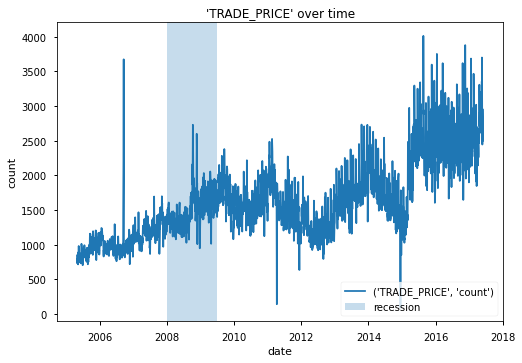

In [34]:
trades_per_day = plot_time_series("TRADE_PRICE", "count")


In [35]:
trades_per_day.iloc[:, 0].nlargest(N)


date
2015-08-21    4013
2016-11-18    3880
2016-01-15    3753
2017-05-19    3701
2017-01-20    3686
2006-09-19    3675
2016-10-21    3620
2016-03-18    3619
2015-11-20    3599
2017-02-17    3467
Name: (TRADE_PRICE, count), dtype: int64

In [36]:
trades_per_day.iloc[:, 0].nsmallest(N)


date
2014-12-15     93
2011-04-11    144
2011-12-12    637
2005-06-30    706
2005-05-11    718
2005-08-25    719
2006-11-24    721
2005-08-26    726
2005-05-06    729
2005-06-10    733
Name: (TRADE_PRICE, count), dtype: int64

**Observation:**
* Number of trades increases over time.
* There is no obvious explanation why the number of trades spikes at certain days.

#### Trade size

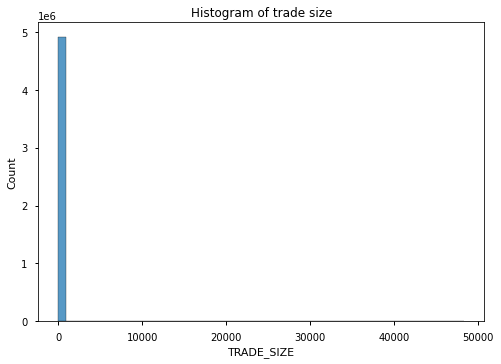

In [37]:
ax = sns.histplot(data, x="TRADE_SIZE", bins=50)  # type: ignore
ax.title.set_text("Histogram of trade size")


**Observation:**
* highly skewed with few outliers.
* Similar to the price, $\log(\cdot)$ transform could help.

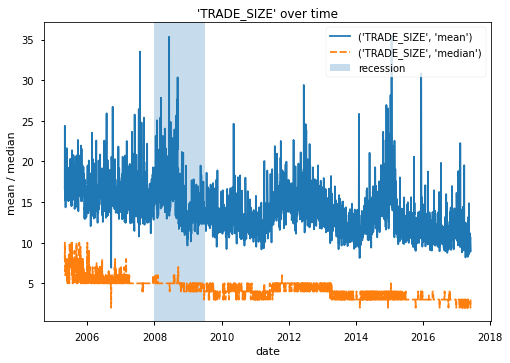

In [38]:
trades_over_time = plot_time_series("TRADE_SIZE", ["mean", "median"])


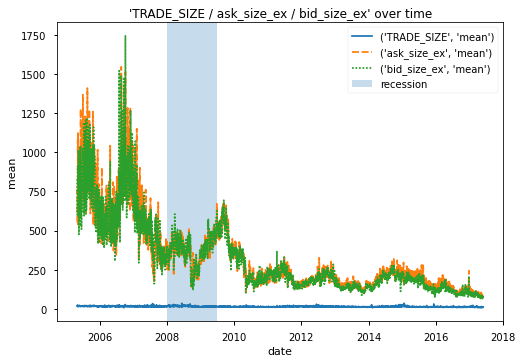

In [39]:
trade_ask_bid_size = plot_time_series(
    ["TRADE_SIZE", "ask_size_ex", "bid_size_ex"], "mean"
)


**Observation:**
* There is a slow downward trend in `TRADE_SIZE` (mean).
* Controversely, the number of trades per day (mean) increases over time.
* Market share of ISE has decrease over time, as reported in https://www.sifma.org/wp-content/uploads/2022/03/SIFMA-Insights-Market-Structure-Compendium-March-2022.pdf. 

In [40]:
data["TRADE_SIZE"].describe()


count    4.920375e+06
mean     1.360620e+01
std      7.674520e+01
min      1.000000e+00
25%      1.000000e+00
50%      4.000000e+00
75%      1.000000e+01
max      4.833200e+04
Name: TRADE_SIZE, dtype: float64

In [41]:
data[data["TRADE_SIZE"].max() == data["TRADE_SIZE"]]


,QUOTE_DATETIME,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,BEST_ASK,ask_ex,...,special_code,security_type,bin_ROOT,bin_OPTION_TYPE,bin_date,bin_TRADE_SIZE_binned,bin_year_binned,bin_ttm_binned,bin_special_code,bin_security_type
39949553,2015-12-11 15:22:27,SVU,2016-01-15,5.0,C,48332,1.7,1.55,1.75,1.75,...,NaN,stock option,625,1,1739,2,1,0,-1,0


In [42]:
data.nlargest(N, "TRADE_SIZE", keep="first").T


,39949553,47165585,30910096,34933497,5732573,45655694,8555040,48881325,5609475,47913065
QUOTE_DATETIME,2015-12-11 15:22:27,2017-02-08 10:48:04,2014-02-03 15:51:17,2015-01-23 15:50:44,2007-07-30 09:39:07,2016-11-11 16:00:42,2008-06-10 14:15:36,2017-05-15 15:22:08,2007-07-16 10:10:40,2017-03-23 10:47:27
ROOT,SVU,USO,XLF,USO,XLB,XLF,QQQ,T,SFB,USO
EXPIRATION,2016-01-15 00:00:00,2017-05-19 00:00:00,2014-02-22 00:00:00,2015-02-20 00:00:00,2007-09-22 00:00:00,2017-02-17 00:00:00,2008-09-20 00:00:00,2017-07-21 00:00:00,2007-08-18 00:00:00,2017-10-20 00:00:00
STRK_PRC,5.0,10.5,18.0,16.5,36.0,19.0,44.0,42.0,140.0,9.0
OPTION_TYPE,C,P,P,P,P,P,P,C,P,P
TRADE_SIZE,48332,30000,26724,23643,21000,20000,20000,16773,16500,15000
TRADE_PRICE,1.7,0.41,0.02,0.86,0.58,0.24,1.17,0.09,0.3,0.5
BEST_BID,1.55,0.39,0.02,0.83,0.55,0.23,1.15,0.06,0.25,0.48
BEST_ASK,1.75,0.42,0.03,0.84,0.65,0.24,1.19,0.07,0.3,0.54
ask_ex,1.75,0.42,0.04,0.86,0.65,0.24,1.19,0.09,0.3,0.54


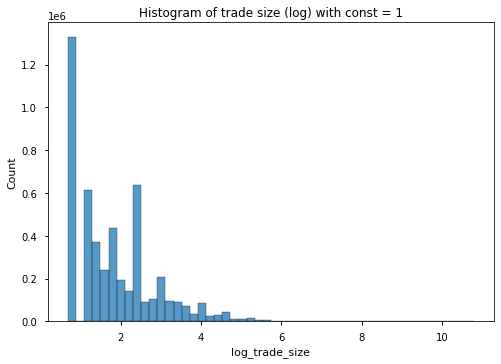

In [43]:
# const not really needed here, due to the trade size being >=1
const = 1
data["log_trade_size"] = np.log(data["TRADE_SIZE"] + const)
ax = sns.histplot(data, x="log_trade_size", bins=50)  # type: ignore
ax.title.set_text(f"Histogram of trade size (log) with const = {const}")


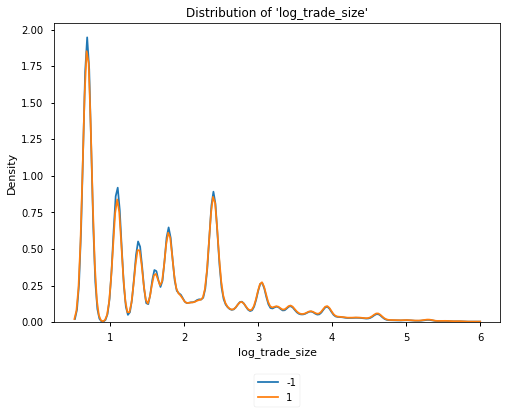

The correlation between 'log_trade_size' and the 'buy_sell' is  0.0132
Median value of sells =  1.6094
Median value of buys =  1.6094


In [44]:
plot_kde_target("log_trade_size", clip=[0, 6])


**Observation:**
- Size features do hardly profit from a $\log$ transform. Might want to keep as-is.

#### Trade price

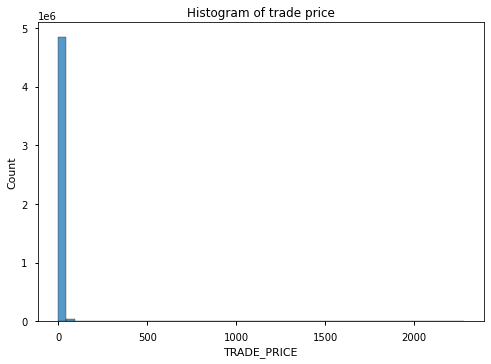

In [45]:
ax = sns.histplot(data, x="TRADE_PRICE", bins=50)  # type: ignore
ax.title.set_text("Histogram of trade price")


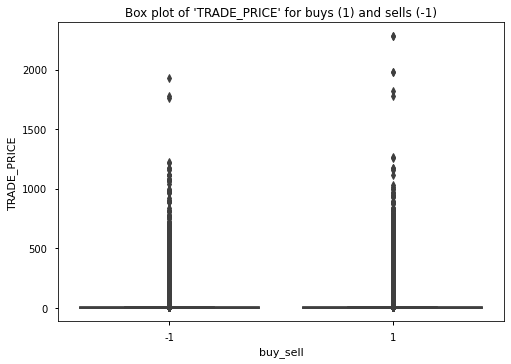

In [46]:
ax = sns.boxplot(data=data, x="buy_sell", y="TRADE_PRICE")
ax.title.set_text("Box plot of 'TRADE_PRICE' for buys (1) and sells (-1)")

**Observations:**
* Very few, very large trade prices, many very small trade prices.
* Scaling can be problematic, if outliers affect scaling much. Try $\log(\cdot)$ transform to correct skewness of distribution. Could improve results.
* Trade price is hardly informative, as distribution is very similar.

In [47]:
const = 1e-2
data["log_trade_price"] = np.log(data["TRADE_PRICE"] + const)


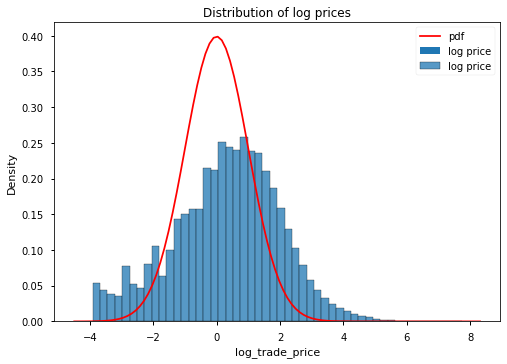

In [48]:
fig, ax = plt.subplots()

sns.histplot(data, x="log_trade_price", bins=50, stat="density", label="log price")  # type: ignore

# extract the limits for the x-axis and fit normal distributon
x0, x1 = ax.get_xlim()
x_pdf = np.linspace(x0, x1, 100)
y_pdf = stats.norm.pdf(x_pdf)

pdf = pd.DataFrame({"x": x_pdf, "y": y_pdf})
sns.lineplot(data=pdf, x="x", y="y", label="pdf", color="r")


ax.title.set_text("Distribution of log prices")
ax.legend()


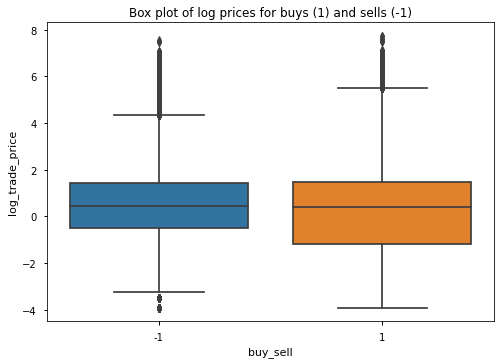

In [49]:
ax = sns.boxplot(data=data, x="buy_sell", y="log_trade_price")
ax.title.set_text("Box plot of log prices for buys (1) and sells (-1)")


In [50]:
data.nlargest(N, "TRADE_PRICE", keep="first").T


,33680345,33680332,32486891,32486793,39437552,38759890,38399924,38354215,38922953,14962176
QUOTE_DATETIME,2014-09-19 12:21:28,2014-09-19 12:21:14,2014-06-06 10:14:12,2014-06-06 10:12:54,2015-11-11 16:02:27,2015-10-05 09:56:59,2015-09-10 15:40:46,2015-09-08 14:30:03,2015-10-14 09:37:19,2009-12-30 12:13:35
ROOT,NDX,NDX,NDX,NDX,NDX,NDX,NDX,NDX,NDX,NDK
EXPIRATION,2014-12-20 00:00:00,2014-12-20 00:00:00,2014-09-20 00:00:00,2014-09-20 00:00:00,2015-11-13 00:00:00,2016-12-16 00:00:00,2016-01-15 00:00:00,2015-12-19 00:00:00,2017-06-16 00:00:00,2010-09-18 00:00:00
STRK_PRC,1800.0,1800.0,1800.0,1800.0,2700.0,6100.0,2500.0,2500.0,6100.0,600.0
OPTION_TYPE,C,C,C,C,C,P,C,C,P,C
TRADE_SIZE,3,1,3,3,1,1,1,1,3,4000
TRADE_PRICE,2281.97998,2281.48999,1975.849976,1975.699951,1932.869995,1816.579956,1776.219971,1775.48999,1761.780029,1266.430054
BEST_BID,2278.100098,2278.100098,1973.5,1973.5,1925.5,1808.0,1766.400024,1773.199951,1756.099976,1264.300049
BEST_ASK,2283.5,2283.5,1981.300049,1981.300049,1940.300049,1822.0,1778.699951,1761.300049,1771.0,1270.099976
ask_ex,2283.5,2283.5,1985.699951,1985.699951,1942.900024,1830.0,1784.0,1761.300049,1772.5,1270.199951


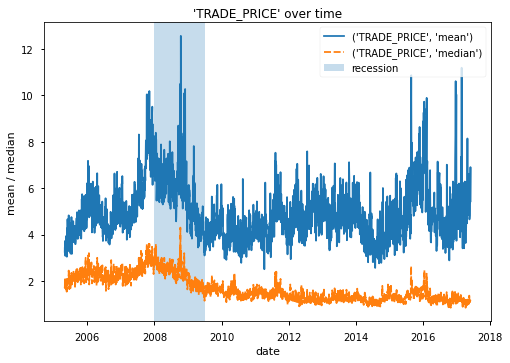

In [51]:
trade_price_over_time = plot_time_series("TRADE_PRICE", ["mean", "median"])


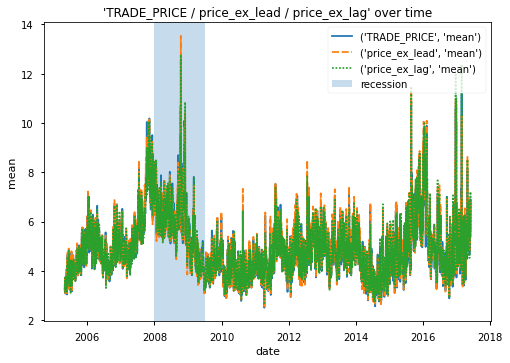

In [52]:
trade_price_over_time = plot_time_series(
    ["TRADE_PRICE", "price_ex_lead", "price_ex_lag"], "mean"
)


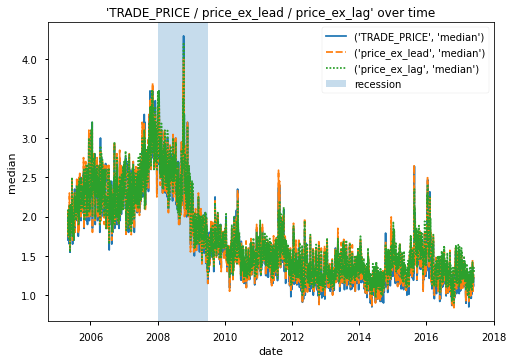

In [53]:
trade_price_over_time = plot_time_series(
    ["TRADE_PRICE", "price_ex_lead", "price_ex_lag"], "median"
)


**Observation:**
* `TRADE_PRICE` remains roughly constant over time. Median decreases over time.
* Large difference between median and mean. 

### Time to maturity ⌚

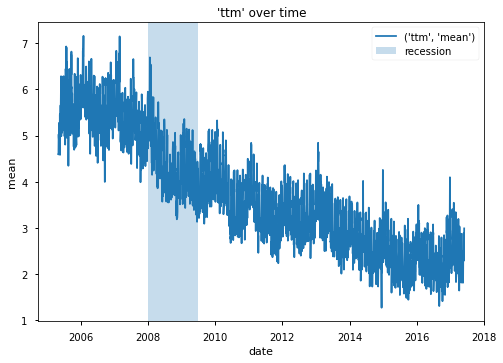

In [54]:
ttm_over_time = plot_time_series("ttm", "mean")


Text(0.5, 0.98, 'Trade Price vs. Time to Maturity')

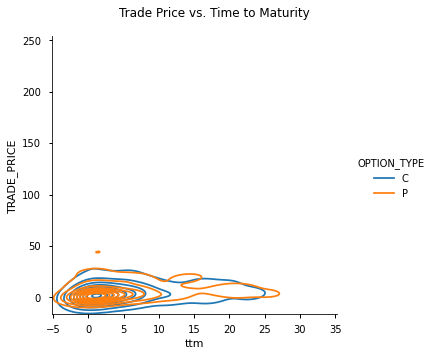

In [55]:
sample = data.sample(n=1000, random_state=seed)

plot = sns.displot(data=sample, x="ttm", y="TRADE_PRICE", kind="kde", hue="OPTION_TYPE")
plot.figure.subplots_adjust(top=0.9)
plot.figure.suptitle("Trade Price vs. Time to Maturity")


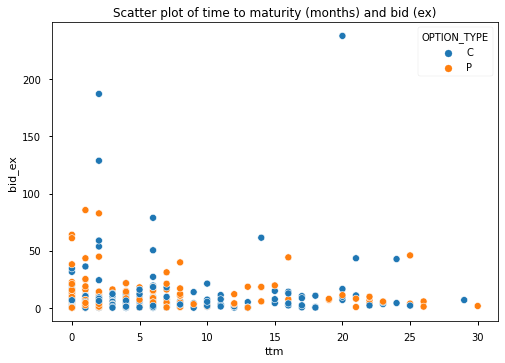

In [56]:
ax = sns.scatterplot(data=sample, x="ttm", y="bid_ex", hue="OPTION_TYPE")
ax.title.set_text("Scatter plot of time to maturity (months) and bid (ex)")


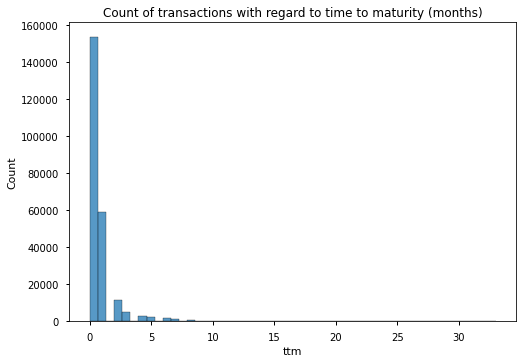

In [57]:
ax = sns.histplot(data=data[data["bid_ex"] == 0.0], x="ttm", bins=50)  # type: ignore
ax.title.set_text("Count of transactions with regard to time to maturity (months)")


**Observation:**
- Most options have a short time-to-maturity
- Binning or cut-off could be helpful

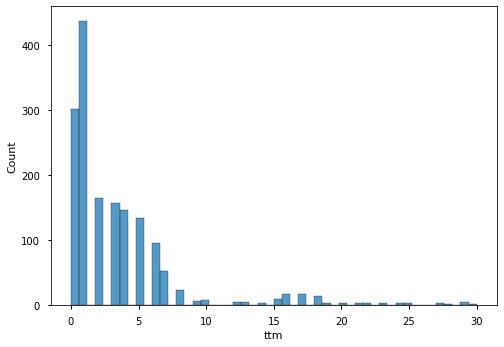

In [58]:
# TODO: ask of zero plausible?
sns.histplot(data=data[data["ask_ex"] == 0.0], x="ttm", bins=50)  # type: ignore


### Strike price

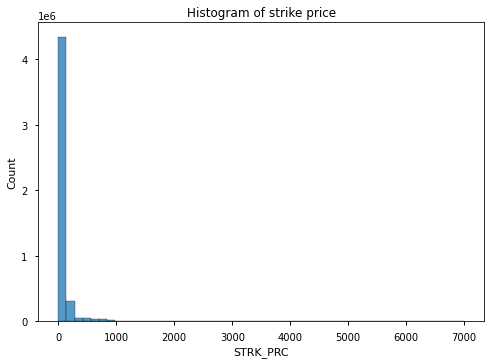

In [59]:
ax = sns.histplot(data, x="STRK_PRC", bins=50)  # type: ignore
ax.title.set_text("Histogram of strike price")


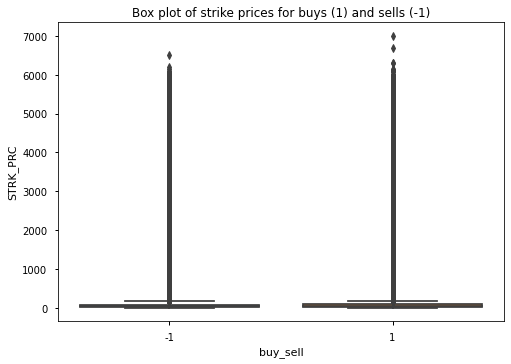

In [60]:
ax = sns.boxplot(data=data, x="buy_sell", y="STRK_PRC")
ax.title.set_text("Box plot of strike prices for buys (1) and sells (-1)")


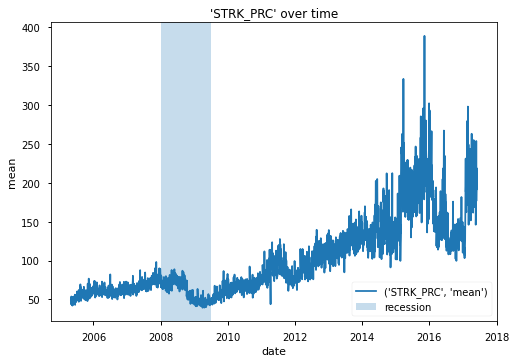

In [61]:
strike_over_time = plot_time_series("STRK_PRC", "mean")


**Observation:**
- Distribution of strike price is highly skewed
- Average strike price grows over time. Thus, very large and previously unobserved trade prices could be part of the test set, but not in the train set.
- Try $\log$

In [62]:
const = 1e-2
data["log_strk_prc"] = np.log(data["STRK_PRC"] + const)


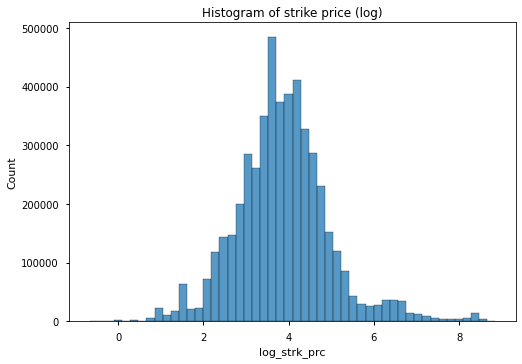

In [63]:
ax = sns.histplot(data, x="log_strk_prc", bins=50)  # type: ignore
ax.title.set_text("Histogram of strike price (log)")


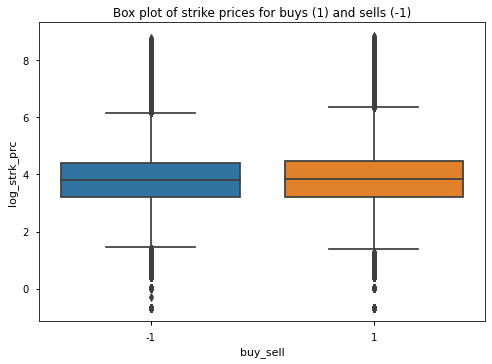

In [64]:
ax = sns.boxplot(data=data, x="buy_sell", y="log_strk_prc")
ax.title.set_text("Box plot of strike prices for buys (1) and sells (-1)")


### Buy Sell 👛

In [65]:
ratio_buy_sell = data["buy_sell"].value_counts() / data["buy_sell"].count()
ratio_buy_sell.head()


-1    0.52569
 1    0.47431
Name: buy_sell, dtype: float64

**Observation:**
* Ratios similar to the one reported in Grauer et. al. Yet not identical as calculation is done on a sample.
* As both classes have a $\approx~0.5$ probability, I would not rebalance. Rebalancing through sampling etc. itself has a bias.
* Ratios seem to be stable over time (see below). Thus, distribution is similar for training, validation, and test set.
* With regard to time-to-maturity the distribution changes slightly for longer periods.

#### By option type

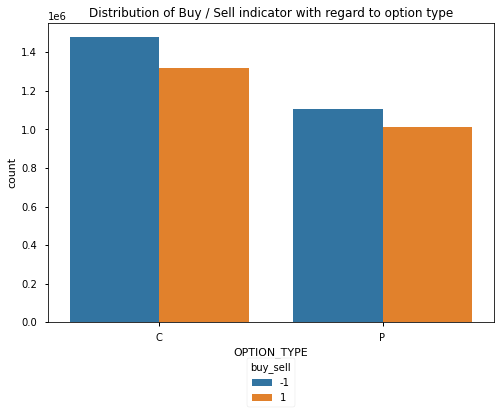

In [66]:
ax = sns.countplot(data=data, x="OPTION_TYPE", hue="buy_sell")
ax.title.set_text("Distribution of Buy / Sell indicator with regard to option type")
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))


#### By year

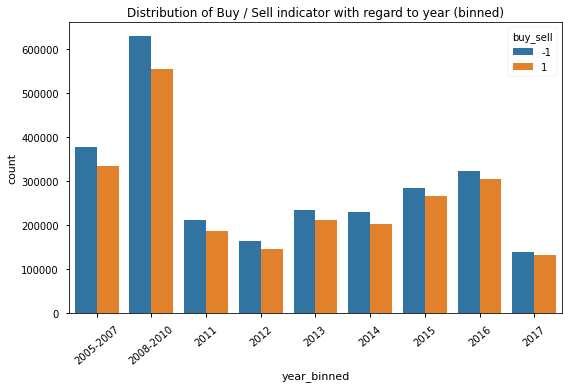

In [67]:
ax = sns.countplot(data=data, x="year_binned", hue="buy_sell")
ax.title.set_text("Distribution of Buy / Sell indicator with regard to year (binned)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="center")
plt.tight_layout()
plt.show()


#### By time time to maturity

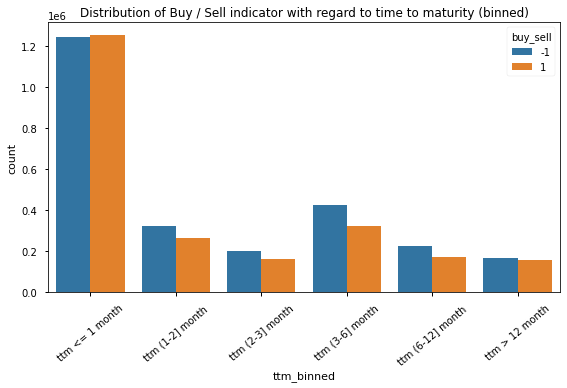

In [68]:
ax = sns.countplot(data=data, x="ttm_binned", hue="buy_sell")
ax.title.set_text(
    "Distribution of Buy / Sell indicator with regard to time to maturity (binned)"
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="center")
plt.tight_layout()
plt.show()


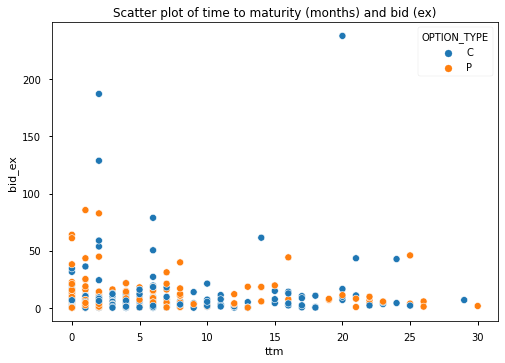

In [69]:
ax = sns.scatterplot(data=sample, x="ttm", y="bid_ex", hue="OPTION_TYPE")
ax.title.set_text("Scatter plot of time to maturity (months) and bid (ex)")


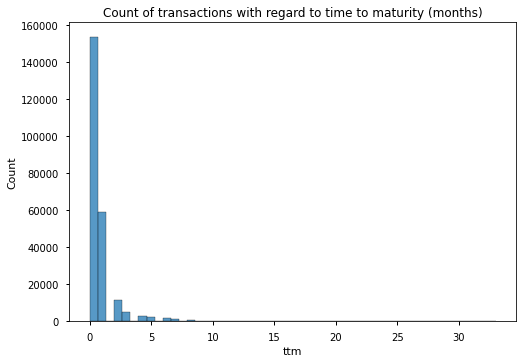

In [70]:
ax = sns.histplot(data=data[data["bid_ex"] == 0.0], x="ttm", bins=50)  # type: ignore
ax.title.set_text("Count of transactions with regard to time to maturity (months)")


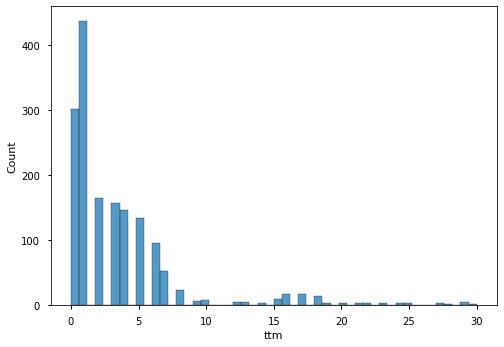

In [71]:
# TODO: ask of zero plausible?
sns.histplot(data=data[data["ask_ex"] == 0.0], x="ttm", bins=50)  # type: ignore


#### Over time

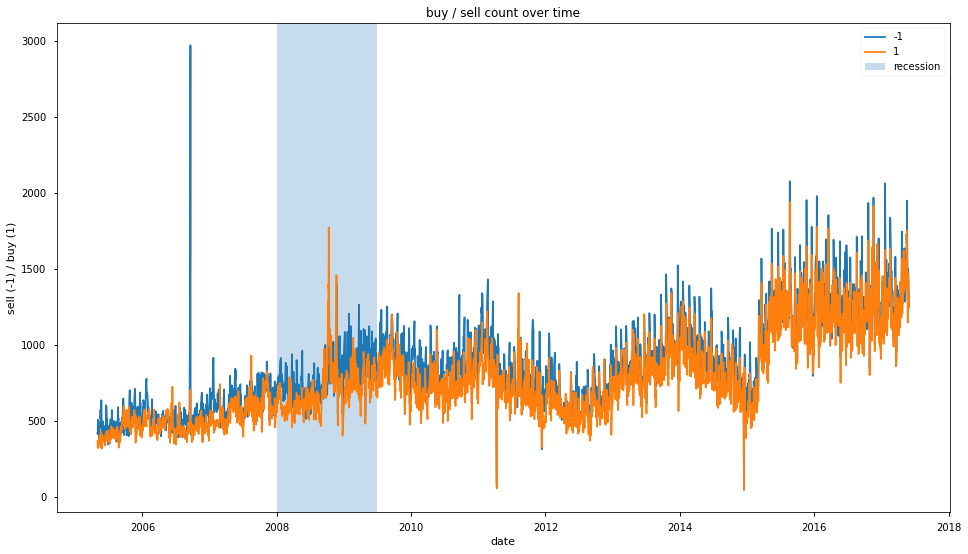

In [72]:
trades_over_time = (
    data.groupby(data["date"])["buy_sell"].value_counts().unstack(fill_value=0)
)
ax = trades_over_time.plot(
    kind="line",
    figsize=ratio,
    title="buy / sell count over time",
    xlabel="date",
    ylabel="sell (-1) / buy (1)",
)
plot_recessions()
ax.legend()
plt.show()


### $n$ most frequent symbols, indices, and special codes 🔢

In [73]:
alphanumeric_symbols = data[~data["ROOT"].str.isalpha()]
alphanumeric_symbols.drop_duplicates(inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [74]:
overlong_symbols = data[data["ROOT"].str.len() >= 5]
overlong_symbols.drop_duplicates(inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Symbol,Count
0,SPY,95749
1,AAPL,48434
2,IWM,42842
3,GLD,38269
4,NDX,34056
5,AMZN,31837
6,VXX,30385
7,QQQ,30301
8,TLT,29513
9,PCLN,29284


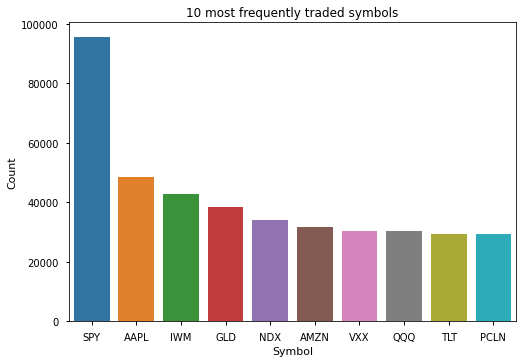

In [75]:
most_frequent_symbols = data["ROOT"].value_counts().head(N).reset_index(name="Count")
most_frequent_symbols.rename(columns={"index": "Symbol"}, inplace=True)

ax = sns.barplot(data=most_frequent_symbols, x="Symbol", y="Count")
ax.title.set_text(f"{N} most frequently traded symbols")

most_frequent_symbols.head(N)


In [76]:
list_freq_symbols = most_frequent_symbols.Symbol.tolist()


In [77]:
frequent_symbols_over_time = data[data["ROOT"].isin(list_freq_symbols)]


In [78]:
frequent_symbols_trades_per_day = (
    frequent_symbols_over_time.groupby(
        [frequent_symbols_over_time.QUOTE_DATETIME.dt.to_period("m"), "ROOT"]
    )["TRADE_SIZE"]
    .count()
    .reset_index()
    .rename(columns={"TRADE_SIZE": "count", "QUOTE_DATETIME": "date", "ROOT": "Symbol"})
)


In [79]:
frequent_symbols_over_time = (
    frequent_symbols_trades_per_day.groupby(["date", "Symbol"])["count"]
    .first()
    .unstack()
)


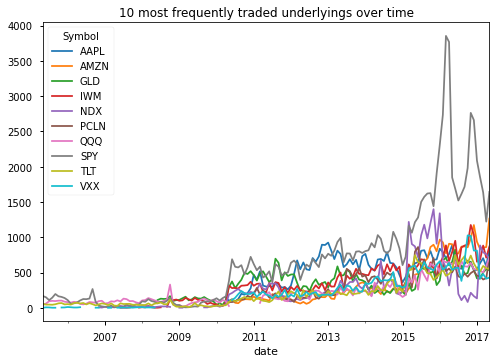

In [80]:
frequent_symbols_over_time.plot(
    kind="line", title=f"{N} most frequently traded underlyings over time"
)


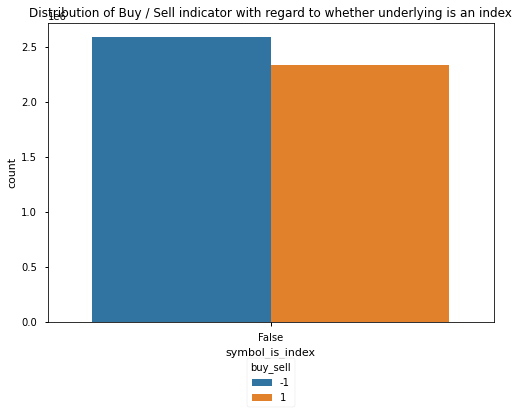

In [81]:
# TODO: investigate why there is no True group
ax = sns.countplot(data=data, x="symbol_is_index", hue="buy_sell")
ax.title.set_text(
    "Distribution of Buy / Sell indicator with regard to whether underlying is an index"
)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))


In [82]:
ratios_is_index = (
    data.groupby(["symbol_is_index", "buy_sell"])["buy_sell"].count()
    / data.groupby(["symbol_is_index"])["buy_sell"].count()
)
ratios_is_index.head()


symbol_is_index  buy_sell
False            -1          0.52569
                  1          0.47431
Name: buy_sell, dtype: float64

**Observation:**
- Feature can be important, as it's much more likely for trade to be sell, rather than buy, if and only if the underlying is no index option.
- Difference isn't too pronounced and could be due to sampling effects.

In [83]:
data["special_code"].value_counts(dropna=False)


NaN    4894823
L        14202
7         4939
A         4498
1         1021
K          263
2          234
3          147
Y          107
B           81
F           43
8           14
P            3
Name: special_code, dtype: int64

**Observation:**
* `L`: Misc. (compare Google Shares)
* `B`: Class "B"
* `A`: Class "A"
* `K`: "Non-voting"
* `Y`: "ADRs"

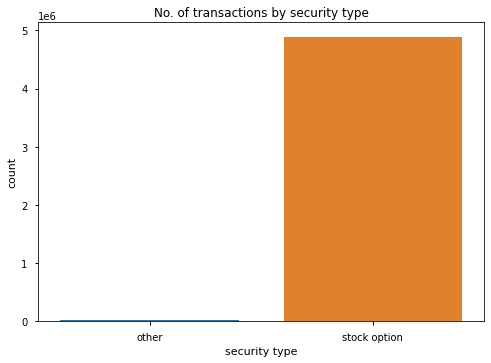

In [84]:
ax = sns.countplot(data=data, x="security_type")
ax.title.set_text("No. of transactions by security type")
ax.xaxis.label.set_text("security type")


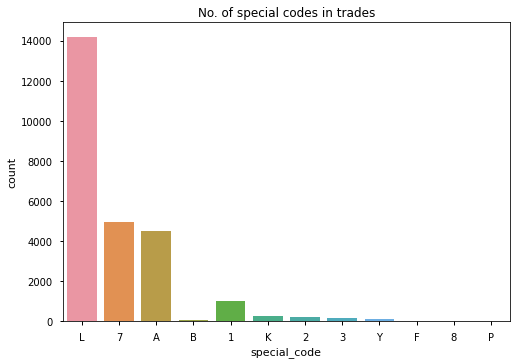

In [85]:
ax = sns.countplot(data=data, x="special_code")
ax.title.set_text("No. of special codes in trades")


###  Ask and bid👨‍⚖️

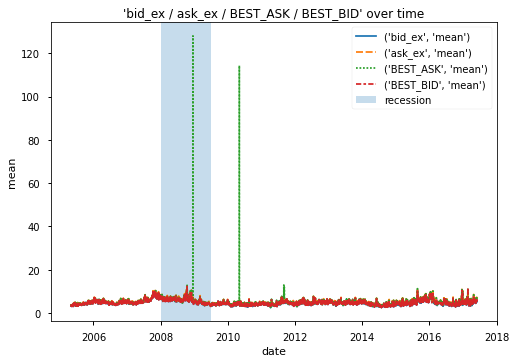

In [86]:
bid_ask_over_time = plot_time_series(
    ["bid_ex", "ask_ex", "BEST_ASK", "BEST_BID"], "mean"
)


#### Ask

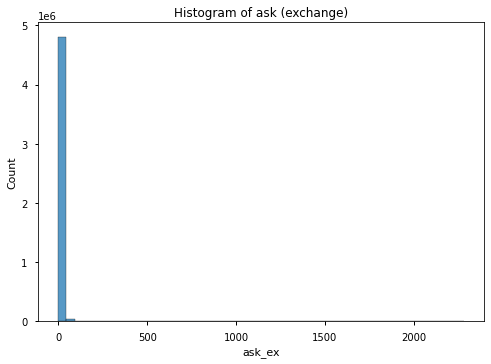

In [87]:
ax = sns.histplot(data, x="ask_ex", bins=50)  # type: ignore
ax.title.set_text("Histogram of ask (exchange)")


**Observation:**
* Distribution is highly skewed, try correction with $\log$

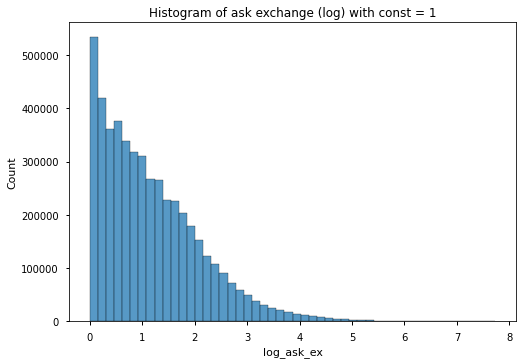

In [88]:
const = 1
data["log_ask_ex"] = np.log(data["ask_ex"] + const)
ax = sns.histplot(data, x="log_ask_ex", bins=50)  # type: ignore
ax.title.set_text(f"Histogram of ask exchange (log) with const = {const}")


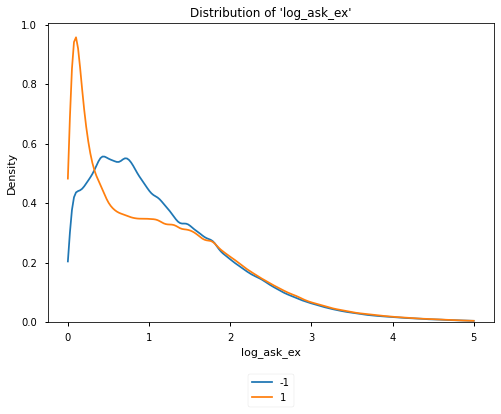

The correlation between 'log_ask_ex' and the 'buy_sell' is -0.0312
Median value of sells =  0.9933
Median value of buys =  0.9439


In [89]:
plot_kde_target("log_ask_ex", clip=[0, 5])


**Observation:**
* Applying a $\log$ transform leads to a easily distinguishable distribution

#### Bid

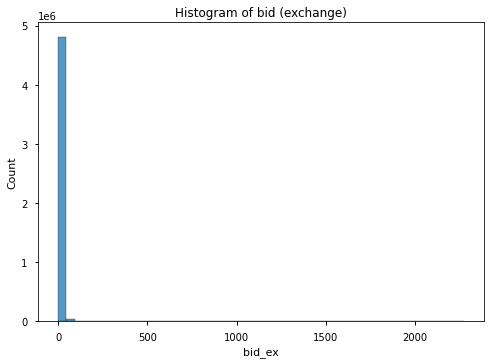

In [90]:
ax = sns.histplot(data, x="bid_ex", bins=50)  # type: ignore
ax.title.set_text("Histogram of bid (exchange)")


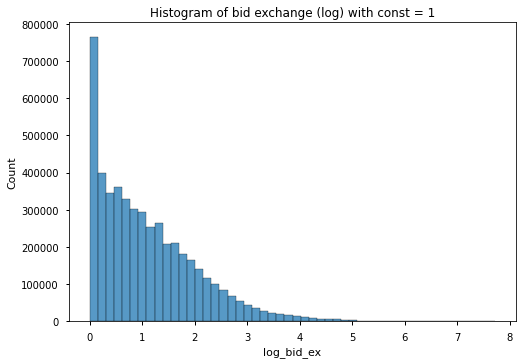

In [91]:
const = 1
data["log_bid_ex"] = np.log(data["bid_ex"] + const)
ax = sns.histplot(data, x="log_bid_ex", bins=50)  # type: ignore
ax.title.set_text(f"Histogram of bid exchange (log) with const = {const}")


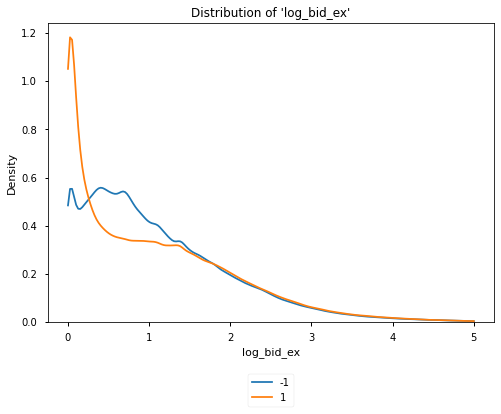

The correlation between 'log_bid_ex' and the 'buy_sell' is -0.0329
Median value of sells =  0.9163
Median value of buys =  0.8544


In [92]:
plot_kde_target("log_bid_ex", clip=[0, 5])


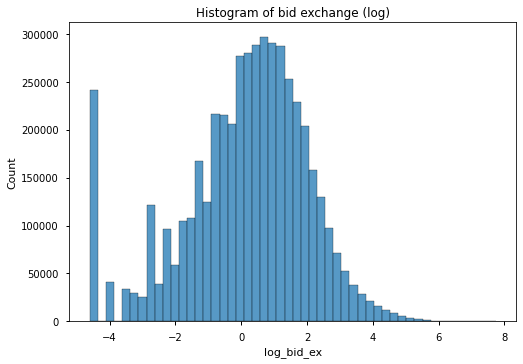

In [93]:
const = 1e-2
data["log_bid_ex"] = np.log(data["bid_ex"] + const)
ax = sns.histplot(data, x="log_bid_ex", bins=50)  # type: ignore
ax.title.set_text("Histogram of bid exchange (log)")


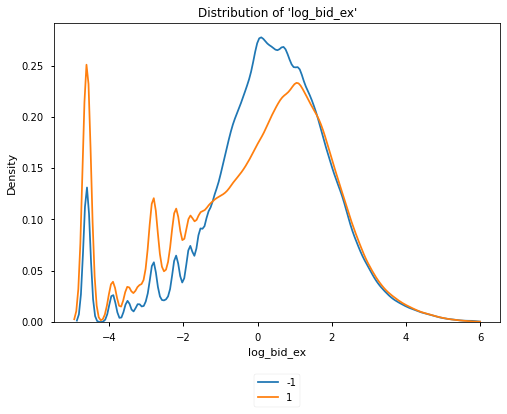

The correlation between 'log_bid_ex' and the 'buy_sell' is -0.0962
Median value of sells =  0.4121
Median value of buys =  0.3075


In [94]:
plot_kde_target("log_bid_ex", clip=[-5, 6])


**Observation:**
- One can choose different constants, but small constants, e. g., `const=1e-2` gives fuzzy, yet distributions that are easier to distinguish. Also note the higher correlation with the target. 
- `TODO:` Look up typical constants to motivate the chosen constant in paper

**Observation:**
- log on size seems to worsen results.
- `TODO:` investigate further, what the reason is. e. g., how many outliers...

# NaNs 🪲

In [95]:
def visualize_nan():
    """
    Visualize NaN values in a heatmap to learn about patterns.
    """
    plt.subplots()
    sns.heatmap(data.head(50).isnull(), cbar=False)
    plt.xlabel("feature")
    plt.ylabel("row")
    plt.title("Missing values (colored in bright beige)")
    plt.show()


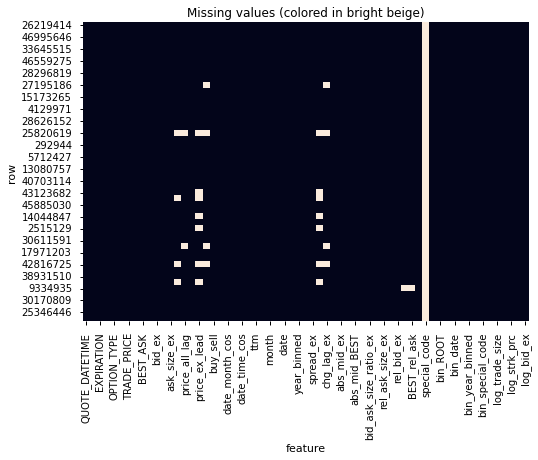

In [96]:
visualize_nan()


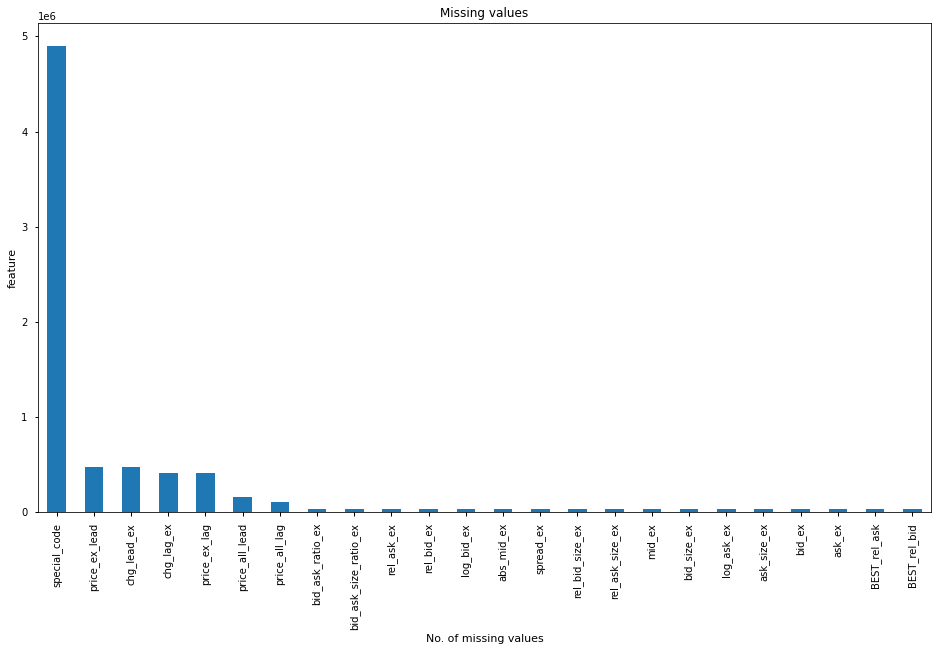

In [97]:
isna_vals = data.isna().sum().sort_values(ascending=False)
isna_vals = isna_vals.loc[lambda x: x > 0]

ax = isna_vals.T.plot(
    kind="bar",
    figsize=ratio,
    legend=False,
    xlabel="No. of missing values",
    ylabel="feature",
    title="Missing values",
)


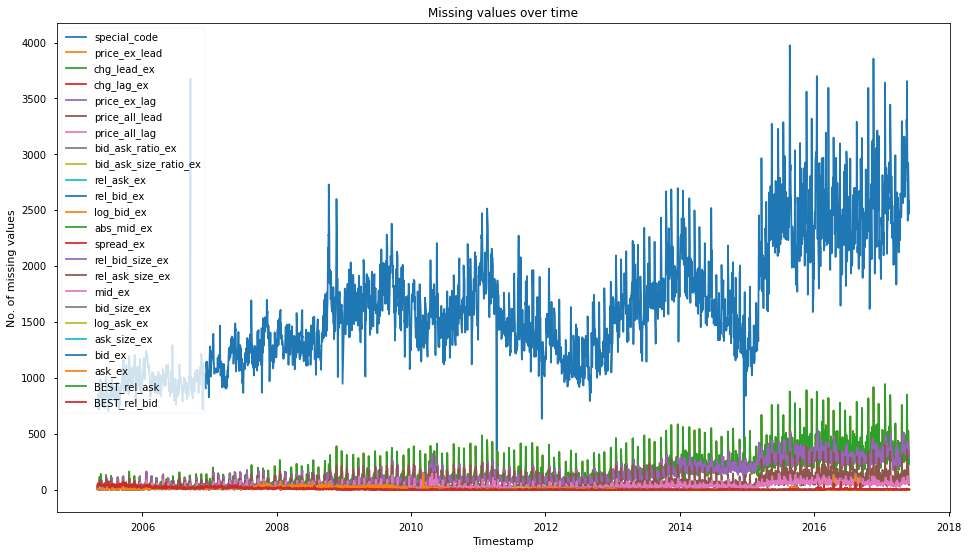

In [98]:
isna_vals_over_time = (
    data[isna_vals.index.tolist()]
    .groupby(data["QUOTE_DATETIME"].dt.date)
    .agg(lambda x: x.isnull().sum())
)
isna_vals_over_time.plot(
    kind="line",
    figsize=ratio,
    title="Missing values over time",
    xlabel="Timestamp",
    ylabel="No. of missing values",
)


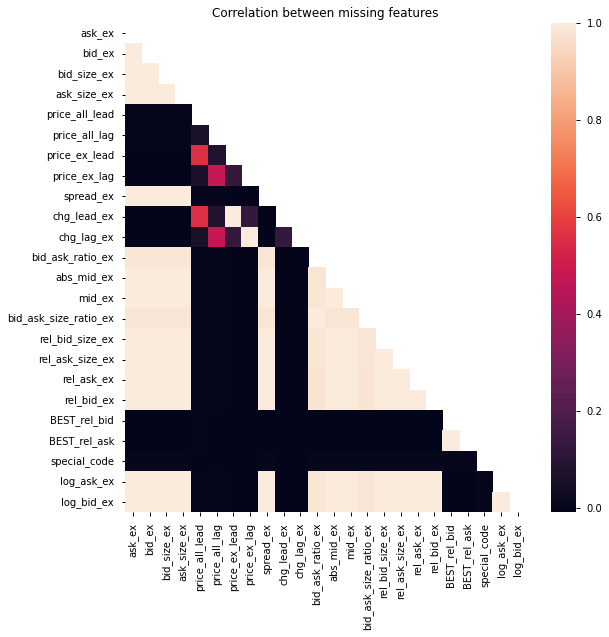

In [99]:
# adapted from: https://github.com/ResidentMario/missingno/blob/master/missingno/missingno.py

isna_data = data.iloc[
    :, [i for i, n in enumerate(np.var(data.isnull(), axis="rows")) if n > 0]
]

corr_mat = isna_data.isnull().corr()
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(9, 9))
ax = sns.heatmap(corr_mat, mask=mask, annot=False, annot_kws={"size": 10}, ax=ax)
ax.title.set_text("Correlation between missing features")


In [100]:
# TODO: Check if there is a pattern between the missing values


**Observation:**
- Note that also important features like `price_all_lead` or `price_ex_lag` are missing. This has an impact, whether it is possible to calculate the classical rules like the trade rule. Consider this when reporting results.
- Missing values become more of a problem towards the end of the data set. At the same time the number of trades also increases.

# Correlations of engineered features 🎲

### Correlations 🎲

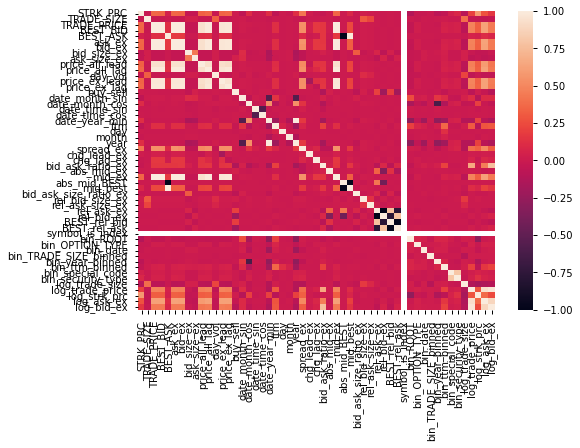

In [101]:
corr = data.corr()

sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)  # type: ignore


### Correlation with target 🎲

In [102]:
sort_criteria = corr["buy_sell"].abs().sort_values(ascending=False)
corr_target = corr.sort_values("buy_sell", ascending=False)["buy_sell"]
corr_target.loc[sort_criteria.index].to_frame()


,buy_sell
buy_sell,1.000000
rel_ask_ex,0.203371
rel_bid_ex,-0.203371
BEST_rel_bid,0.193880
BEST_rel_ask,-0.193880
bid_ask_ratio_ex,-0.130770
log_bid_ex,-0.096190
log_trade_price,-0.071979
bid_ask_size_ratio_ex,-0.064190
ask_size_ex,0.045592


In [103]:
# adapted from here: https://www.kaggle.com/code/willkoehrsen/featuretools-for-good

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.975)]

print(to_drop)


['BEST_BID', 'ask_ex', 'bid_ex', 'price_all_lag', 'price_ex_lead', 'price_ex_lag', 'year', 'mid_ex', 'abs_mid_BEST', 'mid_best', 'rel_bid_ex', 'BEST_rel_ask']


**Observation:**
- Newly engineered features have a high correlation with the target, which is positive. Investigate if the correlation is due to randomness or whether a pattern is observable.
- `_ex` and `BEST_` features seem to be rather redundant, even if a high threshold for correlation is chosen.

### Collinearity of features🎲

In [104]:
# Set the threshold
threshold = 0.975

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corr:
    above_threshold_vars[col] = list(corr.index[corr[col] > threshold])

pd.Series(above_threshold_vars)


STRK_PRC                                                        [STRK_PRC]
TRADE_SIZE                                                    [TRADE_SIZE]
TRADE_PRICE              [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
BEST_BID                 [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
BEST_ASK                                              [BEST_ASK, mid_best]
ask_ex                   [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
bid_ex                   [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
bid_size_ex                                                  [bid_size_ex]
ask_size_ex                                                  [ask_size_ex]
price_all_lead                                            [price_all_lead]
price_all_lag            [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
day_vol                                                          [day_vol]
price_ex_lead            [TRADE_PRICE, BEST_BID, bid_ex, price_ex_lead,...
price_ex_lag             

# Analyses of engineered features

In [105]:
corr_target.loc[sort_criteria.index].to_frame().T


,buy_sell,rel_ask_ex,rel_bid_ex,BEST_rel_bid,BEST_rel_ask,bid_ask_ratio_ex,log_bid_ex,log_trade_price,bid_ask_size_ratio_ex,ask_size_ex,...,BEST_BID,bid_ex,abs_mid_BEST,mid_ex,price_ex_lag,price_all_lag,ask_ex,mid_best,BEST_ASK,symbol_is_index
buy_sell,1.0,0.203371,-0.203371,0.19388,-0.19388,-0.13077,-0.09619,-0.071979,-0.06419,0.045592,...,-0.000423,-0.000362,0.00026,-0.000246,-0.000224,0.000146,-0.000133,-0.000087,-0.000038,NaN


### What works ✔️

#### Trade price vs distance from mid to ask

Similar to `EMO`, where the applied rule depends on whether the trade is at the ask or bid. Similarily `CLVN` uses percentage bounds e. g., $~20~\%$ of spread.

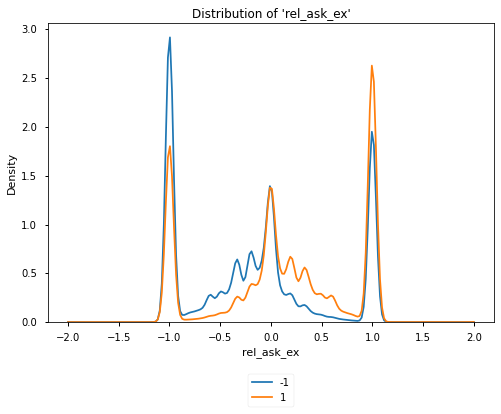

The correlation between 'rel_ask_ex' and the 'buy_sell' is  nan
Median value of sells = -0.2000
Median value of buys =  0.1220


In [106]:
plot_kde_target("rel_ask_ex", clip=[-2, 2])


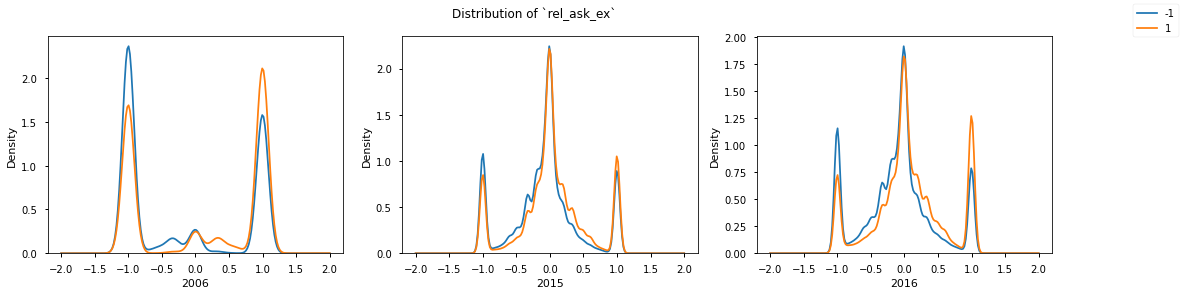

In [107]:
plot_kde_target_comparsion("rel_ask_ex", years=[2006, 2015, 2016], clip=[-2, 2])


#### Depth

Implicitly used in depth rule. Depth rule would assign a buy if `bid_ask_size_ratio_ex` is above one and a sell if it is below zero. But only used for mid-spread trades.

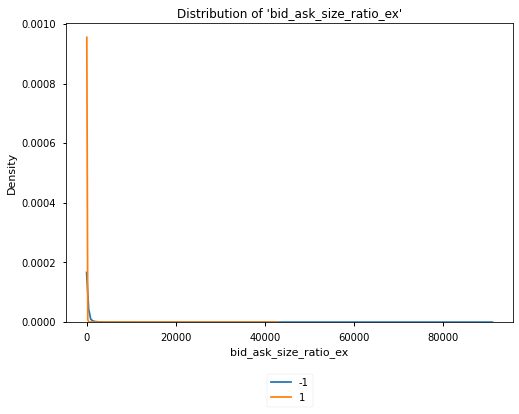

The correlation between 'bid_ask_size_ratio_ex' and the 'buy_sell' is  nan
Median value of sells =  1.3171
Median value of buys =  0.5741


In [108]:
plot_kde_target("bid_ask_size_ratio_ex")


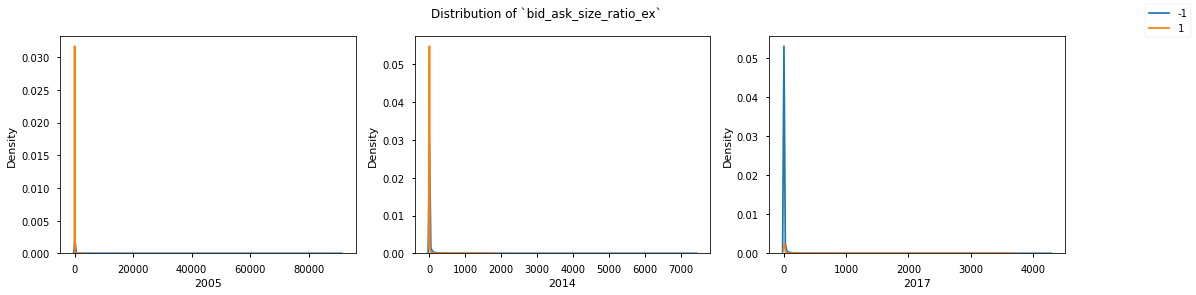

In [109]:
plot_kde_target_comparsion("bid_ask_size_ratio_ex", years=[2005, 2014, 2017])


#### $\log$ bid ex

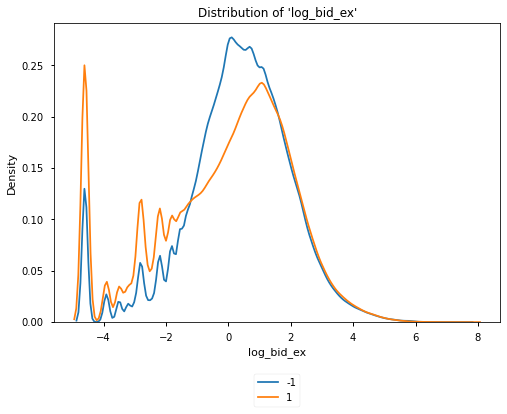

The correlation between 'log_bid_ex' and the 'buy_sell' is -0.0962
Median value of sells =  0.4121
Median value of buys =  0.3075


In [110]:
plot_kde_target("log_bid_ex")


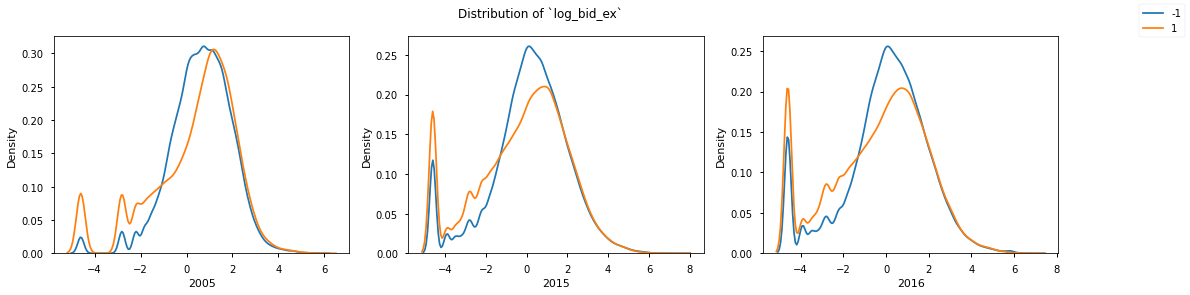

In [111]:
plot_kde_target_comparsion("log_bid_ex", years=[2005, 2015, 2016])


**Observation:**
- Application of the $\log$ leads to highly differentiable distributions, that remain stable over time.

#### $\log$ trade price

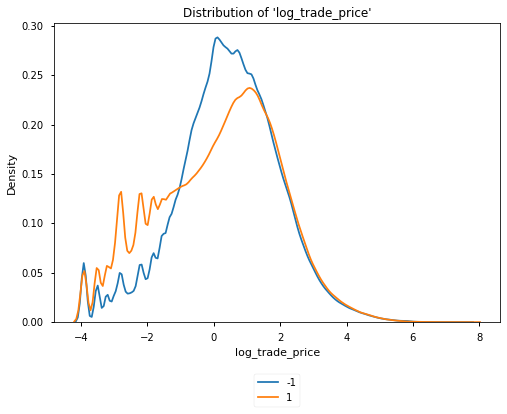

The correlation between 'log_trade_price' and the 'buy_sell' is -0.0720
Median value of sells =  0.4700
Median value of buys =  0.3988


In [112]:
plot_kde_target("log_trade_price")


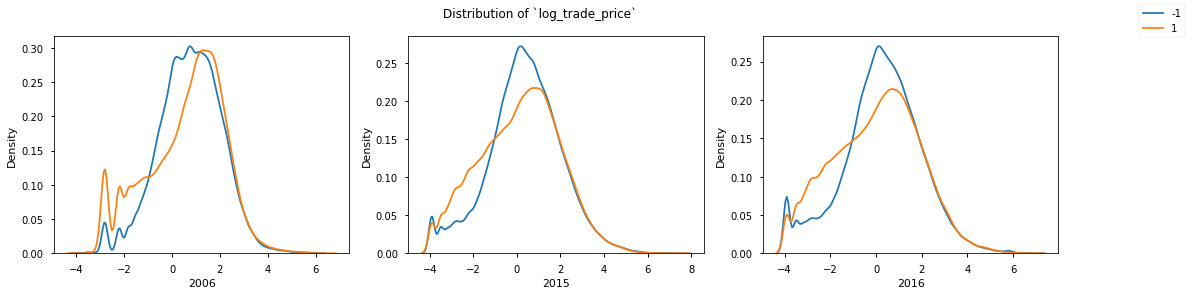

In [113]:
plot_kde_target_comparsion("log_trade_price", years=[2006, 2015, 2016])


**Observation:**
- Application of the $\log$ leads to highly differentiable distributions, that remain stable over time.

#### Ask size

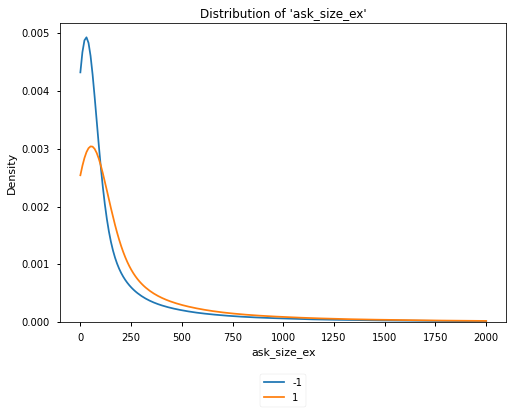

The correlation between 'ask_size_ex' and the 'buy_sell' is  0.0456
Median value of sells =  47.0000
Median value of buys =  84.0000


In [114]:
plot_kde_target("ask_size_ex", clip=[0, 2000])


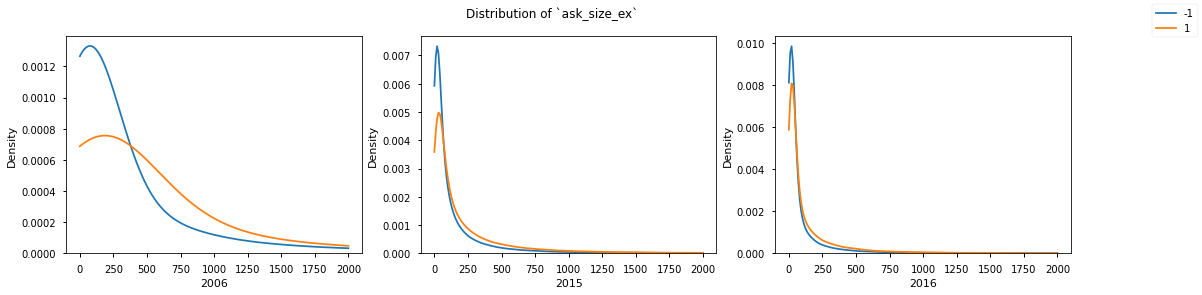

In [115]:
plot_kde_target_comparsion("ask_size_ex", years=[2006, 2015, 2016], clip=[0, 2000])


#### Bid size

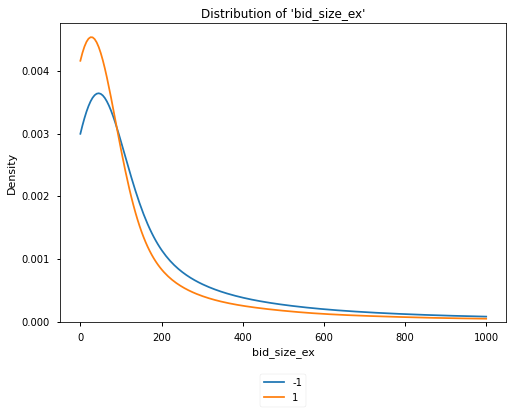

The correlation between 'bid_size_ex' and the 'buy_sell' is -0.0424
Median value of sells =  78.0000
Median value of buys =  38.0000


In [116]:
plot_kde_target("bid_size_ex", clip=[0, 1000])


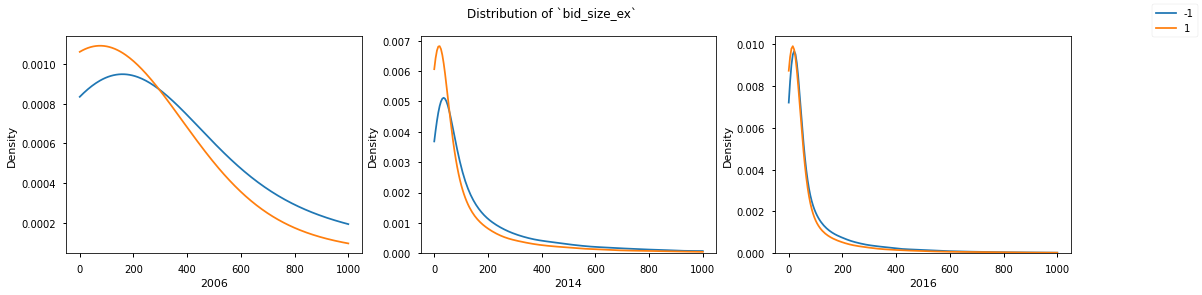

In [117]:
plot_kde_target_comparsion("bid_size_ex", years=[2006, 2014, 2016], clip=[0, 1000])


#### Quote rule

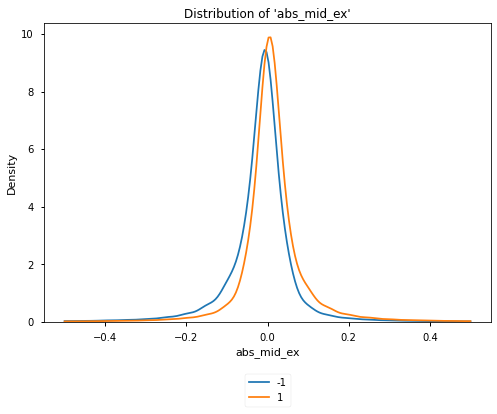

The correlation between 'abs_mid_ex' and the 'buy_sell' is  0.0419
Median value of sells = -0.0050
Median value of buys =  0.0050


In [118]:
plot_kde_target("abs_mid_ex", clip=[-0.5, 0.5])


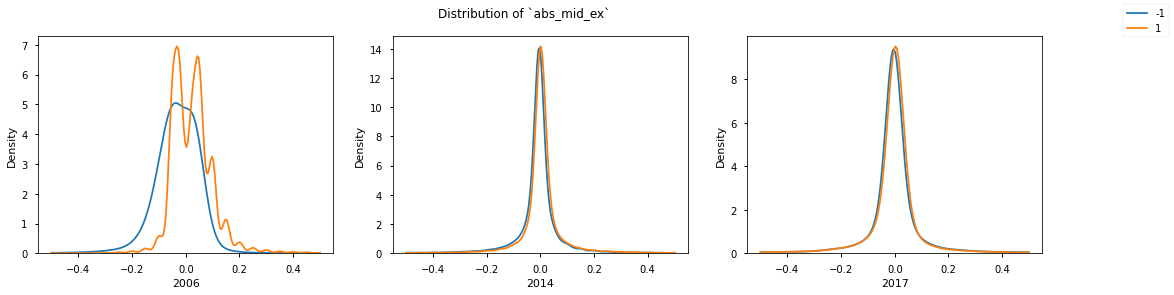

In [119]:
plot_kde_target_comparsion("abs_mid_ex", years=[2006, 2014, 2017], clip=[-0.5, 0.5])


**Observation:**
- Compared with tick rule or reverse tick rule, quote rule is the only classical rule, where distributions are somewhat distinguishable
- On can clearly see that the quote rule works better at the beginning of the data set and its performance worsens over time.

#### Day of the month

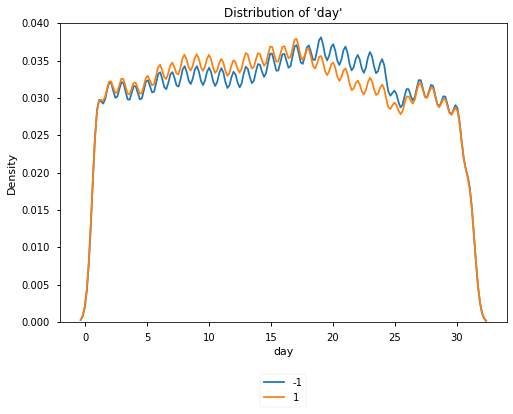

The correlation between 'day' and the 'buy_sell' is -0.0139
Median value of sells =  16.0000
Median value of buys =  15.0000


In [120]:
plot_kde_target("day")


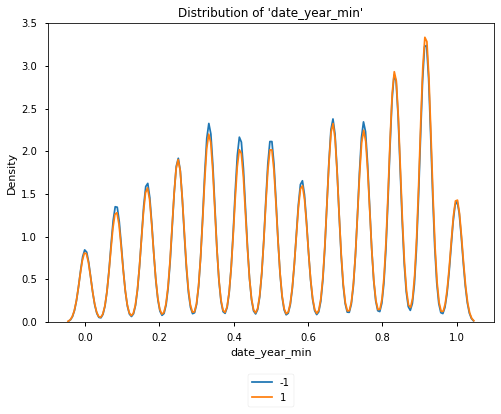

The correlation between 'date_year_min' and the 'buy_sell' is  0.0106
Median value of sells =  0.5833
Median value of buys =  0.5833


In [121]:
plot_kde_target("date_year_min")


**Observation:**
* Judging from the plot there seems to be a seasonal pattern e. g., more buys 
at the beginning of the month and more sells towards the end of the month. 
* Due to the distributions it could make sense to include date features in some feature sets. But do not include in the most basic data set.

## What doesn't ❌

#### tick rule

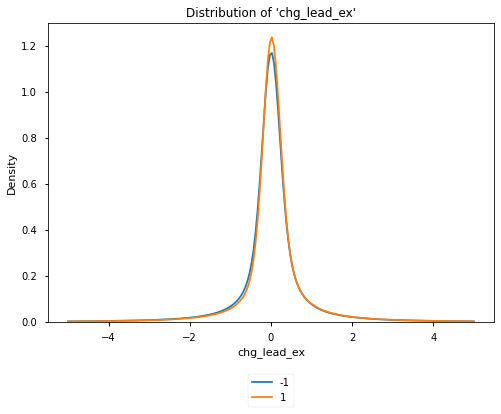

The correlation between 'chg_lead_ex' and the 'buy_sell' is  0.0062
Median value of sells =  0.0100
Median value of buys =  0.0200


In [122]:
plot_kde_target("chg_lead_ex", clip=[-5, 5])


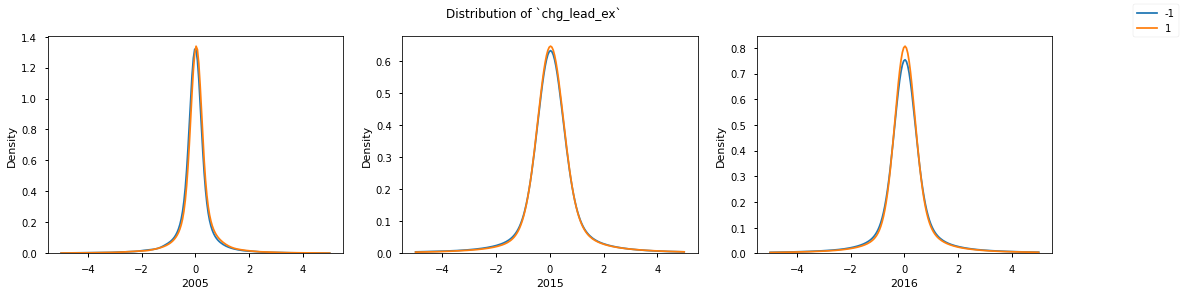

In [123]:
plot_kde_target_comparsion("chg_lead_ex", years=[2005, 2015, 2016], clip=[-5, 5])


**Observation:**
- Distributions are hardly distinguishable. 
- Results seem to worsen over time, which is consistent to the observations of Grauer et. al.

#### reverse tick rule

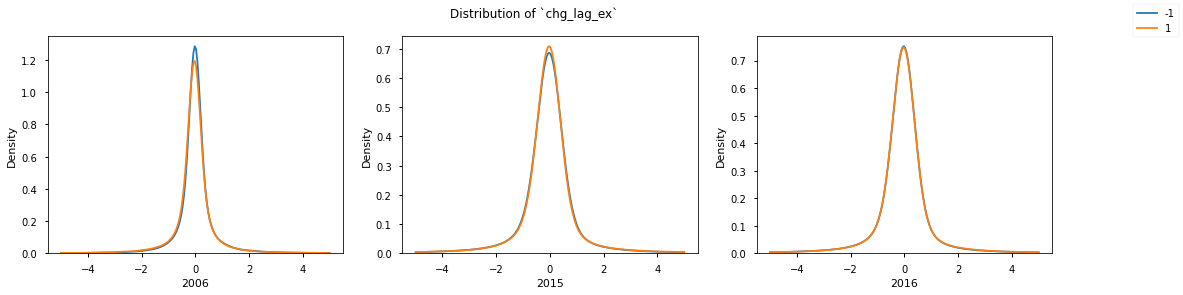

In [124]:
plot_kde_target_comparsion("chg_lag_ex", years=[2006, 2015, 2016], clip=[-5, 5])


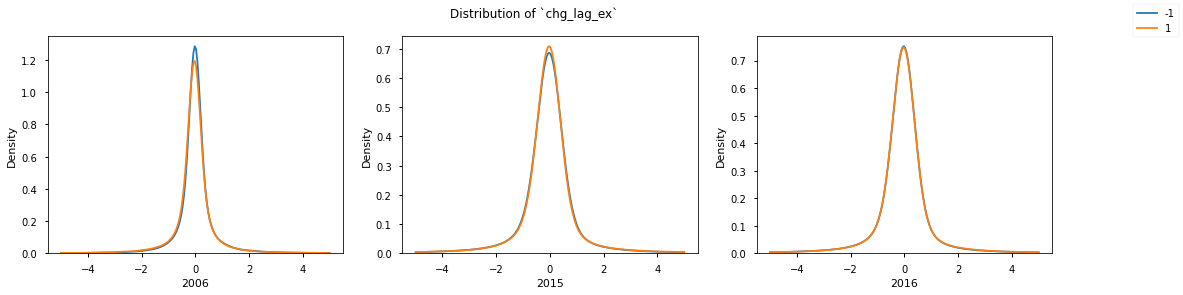

In [125]:
plot_kde_target_comparsion("chg_lag_ex", years=[2006, 2015, 2016], clip=[-5, 5])


**Observation:**
- Distributions are hardly distinguishable. 
- Results worsen over time.

# Impact of scaling 🔢

In [139]:
del [[dfs, files]]

In [126]:
from sklearn.preprocessing import StandardScaler

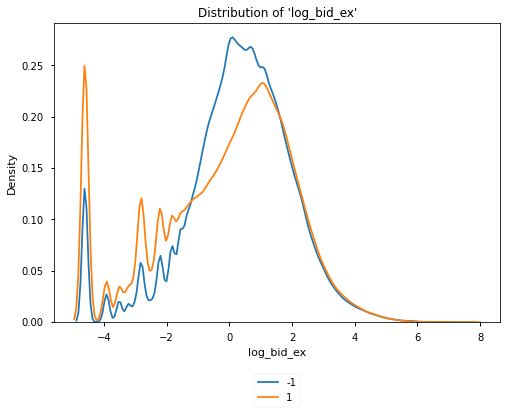

The correlation between 'log_bid_ex' and the 'buy_sell' is -0.0962
Median value of sells =  0.4121
Median value of buys =  0.3075


In [140]:
plot_kde_target("log_bid_ex", clip=[-5,8])

In [128]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [141]:
scaler = StandardScaler()
data["log_bid_ex_scaled"] = scaler.fit_transform(X=data["log_bid_ex"].values.reshape(-1,1))

In [142]:
data["log_bid_ex_scaled"].describe()

count    4.883226e+06
mean     7.461590e-18
std      1.000000e+00
min     -2.458204e+00
25%     -5.301973e-01
50%      1.291773e-01
75%      6.727979e-01
max      3.946522e+00
Name: log_bid_ex_scaled, dtype: float64

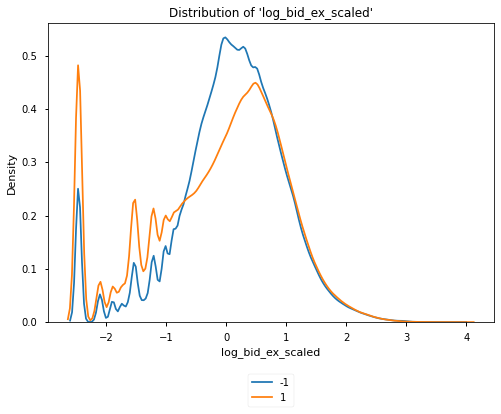

The correlation between 'log_bid_ex_scaled' and the 'buy_sell' is -0.0962
Median value of sells =  0.1467
Median value of buys =  0.0923


In [143]:
plot_kde_target("log_bid_ex_scaled", clip=[-5,5])

# Cross-validation⛑️

In [133]:
# TODO: Perform cross-validation
# https://www.kaggle.com/code/willkoehrsen/introduction-to-manual-feature-engineering/notebook


# Conclusion 🔗

**Observation:**
- log on size seems to worsen results, but improves results for prices
- `TODO:` investigate further, what the reason is. e. g., some skewness, but outliers...
- `TODO:` investigate further, if there is an economic intuition behind it
- Classical features have hardly any importance. But keep them for comparsion
- Features of Grauer et. al seem to work
- Binning gives mixed results e. g., for trade size and ttm
- `TODO:` update [feature proposal](https://github.com/KarelZe/thesis/blob/main/references/obsidian/%F0%9F%8D%ACImplementation/%F0%9F%A7%AAFeature%20Engineering/%F0%9F%A7%83Feature%20Sets.md) accordingly
- `TODO:` Correlation is a common method for feature selection https://en.wikipedia.org/wiki/Feature_selection#Filter_method
- `TODO:` Perform cross-validation and calculate AUC on train, validation and test set
- `TODO:` Remove highly correlated columns if possible
- `TODO:` Results are not suprising, when compared with feature importances of first gbm (taken from [this notebook](https://github.com/KarelZe/thesis/blob/d0e078a8030e1ba47b761b4a1abfc699a629ca0a/notebooks/3.0-mb-feature_engineering_baseline.ipynb)):
```
UNDERLYING_SYMBOL 0.021566366629726046
STRK_PRC 0.009127319935855806
OPTION_TYPE 0.005046634536154527
TRADE_SIZE 0.02387199423754382
TRADE_PRICE 0.005713157136252193
BEST_BID 0.021382350572243275
BEST_ASK 0.010634148143876284
ask_ex 0.02105069450386549
bid_ex 0.004026117456655969
bid_size_ex 0.15678191442629613
ask_size_ex 0.14079564200719413
price_all_lead 0.007502007413328573
price_all_lag 0.0006435968556699435
day_vol 0.07305687183934556
price_ex_lead 0.0012276493027704556
price_ex_lag 0.0015678783924615502
time_to_maturity 0.024955327521460076
date_month_sin 0.028046528183426834
date_month_cos 0.0178607911888709
mid_ex 0.0012948919276966858
abs_mid_ex 0.28364371496098023
rel_bid_size_ex 0.07208704474907267
rel_ask_size_ex 0.06640793782355861
sgn_chg_ex_lead 0.0017094202556935758
```